Calculating rate of replication of true associations between studies 

In [1]:
#loading necessary packages
options(scipen=999)
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(purrr))
suppressPackageStartupMessages(library(VennDiagram))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(patchwork))

Warning message:
“package ‘data.table’ was built under R version 4.2.2”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”
Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘ggpubr’ was built under R version 4.2.3”
Warning message:
“package ‘purrr’ was built under R version 4.2.2”
Warning message:
“package ‘VennDiagram’ was built under R version 4.2.1”
Warning message:
“package ‘futile.logger’ was built under R version 4.2.1”
Warning message:
“package ‘RColorBrewer’ was built under R version 4.2.1”


In [2]:
#reading the summary stats files
#these files are generated from the jupyter notebook titled "getting_variants_with_MAF_morethan_0.005"
diamante18 <- fread("/lustre/groups/itg/teams/zeggini/users/archit.singh/lambda/summary_statistics/T2D/Mahajan.NatGenet2018b.T2D.European.undajusted.BMI/Mahajan.NatGenet2018b.T2D.European.txt", header = TRUE)
diamante22 <- fread("/lustre/groups/itg/teams/zeggini/users/archit.singh/lambda/summary_statistics/T2D/Mahajan.NatGen2022.DIAMANTE-EUR.sumstat/DIAMANTE-EUR.sumstat.txt", header = TRUE)
t2dggi <- fread("/lustre/groups/itg/teams/zeggini/users/archit.singh/lambda/summary_statistics/T2D/T2DGGI/T2D_GGI_EUR_MetalFixed_2023.txt", header = TRUE)

In [3]:
#adding unique id for each variant to the summary stats file comprising of -> chr:pos:effect-allele:non-effect-allele
diamante18$id <- paste("chr",diamante18$SNP, sep = "")
diamante18$id <- paste(diamante18$id,":",sep = "")
diamante18$EA <- tolower(diamante18$EA)
diamante18$NEA <- tolower(diamante18$NEA)
diamante18$id <- paste(diamante18$id,diamante18$EA,sep = "")
diamante18$id <- paste(diamante18$id,":",sep = "")
diamante18$id <- paste(diamante18$id,diamante18$NEA,sep = "")

diamante22$id <- paste(diamante22$chrposID,":",sep = "")
diamante22$id <- paste(diamante22$id,diamante22$effect_allele,sep = "")
diamante22$id <- paste(diamante22$id,":",sep = "")
diamante22$id <- paste(diamante22$id,diamante22$other_allele,sep = "")

t2dggi$id <- paste(t2dggi$MarkerName,":",sep = "")
t2dggi$id <- paste(t2dggi$id,t2dggi$Allele1,sep = "")
t2dggi$id <- paste(t2dggi$id,":",sep = "")
t2dggi$id <- paste(t2dggi$id,t2dggi$Allele2,sep = "")

In [54]:
head(diamante18)
head(diamante22)
head(t2dggi)
dim(diamante18)
dim(diamante22)
dim(t2dggi)

SNP,Chr,Pos,EA,NEA,EAF,Beta,SE,Pvalue,Neff,id
<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>
1:100000012,1,100000012,t,g,0.2500,-0.0260,0.0073,4.0e-04,231420,chr1:100000012:t:g
1:10000006,1,10000006,a,g,0.0047,-0.0380,0.0560,4.9e-01,225429,chr1:10000006:a:g
1:100000135,1,100000135,a,t,0.9900,-0.0330,0.0550,5.5e-01,226311,chr1:100000135:a:t
1:100000436,1,100000436,t,c,1.0000,-0.0980,0.1900,6.1e-01,185906,chr1:100000436:t:c
1:100000827,1,100000827,t,c,0.3000,-0.0230,0.0069,7.5e-04,231420,chr1:100000827:t:c
1:100000843,1,100000843,t,c,0.9400,0.0006,0.0140,9.7e-01,231420,chr1:100000843:t:c


chromosome(b37),position(b37),chrposID,rsID,effect_allele,other_allele,effect_allele_frequency,Fixed-effects_beta,Fixed-effects_SE,Fixed-effects_p-value,id
<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,693731,chr1:693731,rs12238997,a,g,0.8747,0.0044,0.0119,0.7124,chr1:693731:a:g
1,706368,chr1:706368,rs55727773,a,g,0.4964,0.0118,0.0099,0.2355,chr1:706368:a:g
1,721290,chr1:721290,rs12565286,c,g,0.0359,-0.0176,0.0262,0.5013,chr1:721290:c:g
1,729679,chr1:729679,rs4951859,c,g,0.1656,-0.0043,0.0105,0.6813,chr1:729679:c:g
1,730087,chr1:730087,rs148120343,t,c,0.9409,0.0001,0.0172,0.9954,chr1:730087:t:c
1,731718,chr1:731718,rs142557973,t,c,0.8694,0.0088,0.0111,0.4278,chr1:731718:t:c


MarkerName,Allele1,Allele2,Freq1,FreqSE,MinFreq,MaxFreq,Effect,StdErr,P-value,Direction,HetISq,HetChiSq,HetDf,HetPVal,id
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<chr>
chr11:88249377,t,c,0.9921,0.0018,0.9881,0.9972,-0.0337,0.0214,0.1146,---++--+-+---+-+++-----+++-+------++,25.7,47.089,35,0.08327,chr11:88249377:t:c
chr15:99906873,t,c,0.0003,0.0001,0.0000,0.0007,-0.0181,0.1689,0.9146,+-????-?????????????++-??????????+??,0.0,5.464,6,0.48590,chr15:99906873:t:c
chr8:135908647,a,g,0.2034,0.0176,0.1449,0.2956,-0.0020,0.0046,0.6633,++-+-+---+++--+---------++-++++--+++,20.1,43.801,35,0.14620,chr8:135908647:a:g
chr12:3871714,a,c,0.9979,0.0009,0.9973,1.0000,-0.0678,0.0918,0.4603,--??+??-+??????????-+--???-??????-??,0.0,9.532,10,0.48250,chr12:3871714:a:c
chr11:97895884,c,g,0.0554,0.0061,0.0369,0.0828,0.0215,0.0081,0.007924,+++-++++-+-+--++-+----++-++--+++++-+,3.0,36.087,35,0.41750,chr11:97895884:c:g
chr7:3134635,a,g,0.9999,0.0000,0.9999,0.9999,-0.1288,0.4230,0.7606,??????????????????????-?????????????,0.0,0.000,0,1.00000,chr7:3134635:a:g


[1] 23465132       11

[1] 10454875       11

[1] 19303703       16

#### Distribution of MAF between original set of SNPs and same set of SNPs

[1] 10269674       36

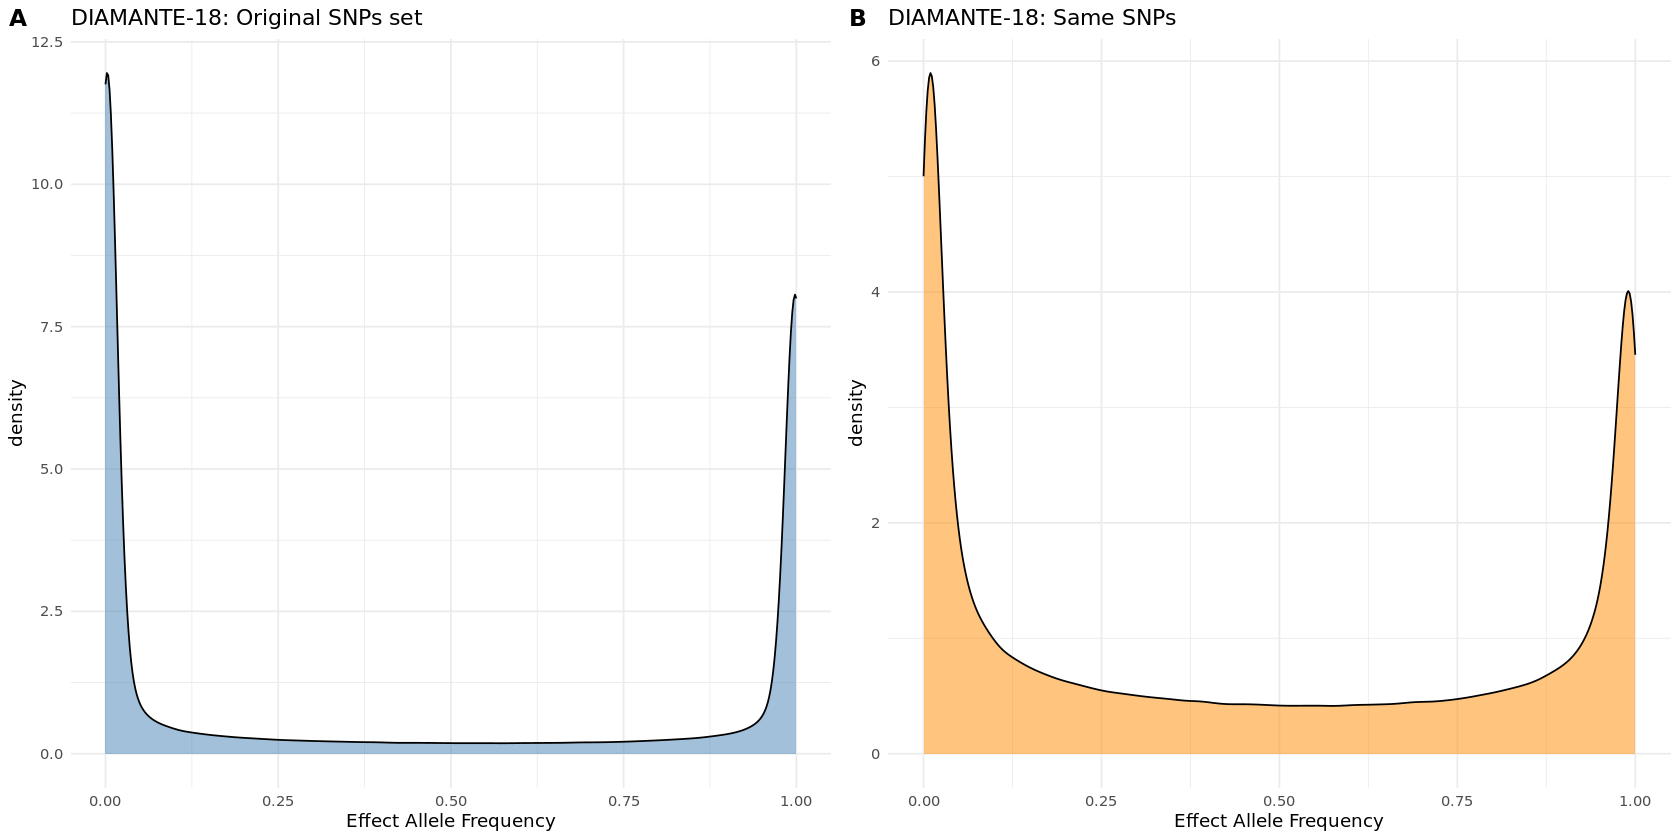

In [11]:
common_rows <- diamante18 %>%
  inner_join(diamante22, by = "id") %>%
  inner_join(t2dggi, by = "id")
dim(common_rows)
diam18 <- semi_join(diamante18, common_rows, by = "id")
diam22 <- semi_join(diamante22, common_rows, by = "id")
t2dggi24 <- semi_join(t2dggi, common_rows, by = "id")

p1 <- ggplot(diamante18, aes(x = EAF)) +
  geom_density(fill = "steelblue", alpha = 0.5) +
  ggtitle("DIAMANTE-18: Original SNPs set") +
  labs(x = "Effect Allele Frequency") +
  #xlim(0, 0.5) +
  theme_minimal()

# Plot 2
p2 <- ggplot(diam18, aes(x = EAF)) +
  geom_density(fill = "darkorange", alpha = 0.5) +
  ggtitle("DIAMANTE-18: Same SNPs") +
  labs(x = "Effect Allele Frequency") +
  #xlim(0, 0.5) +
  theme_minimal()
# Combine side-by-side with shared main title
options(repr.plot.width = 14, repr.plot.height =7) 
plot_2 <- ggarrange(p1, p2, labels = c("A", "B"))
plot_2

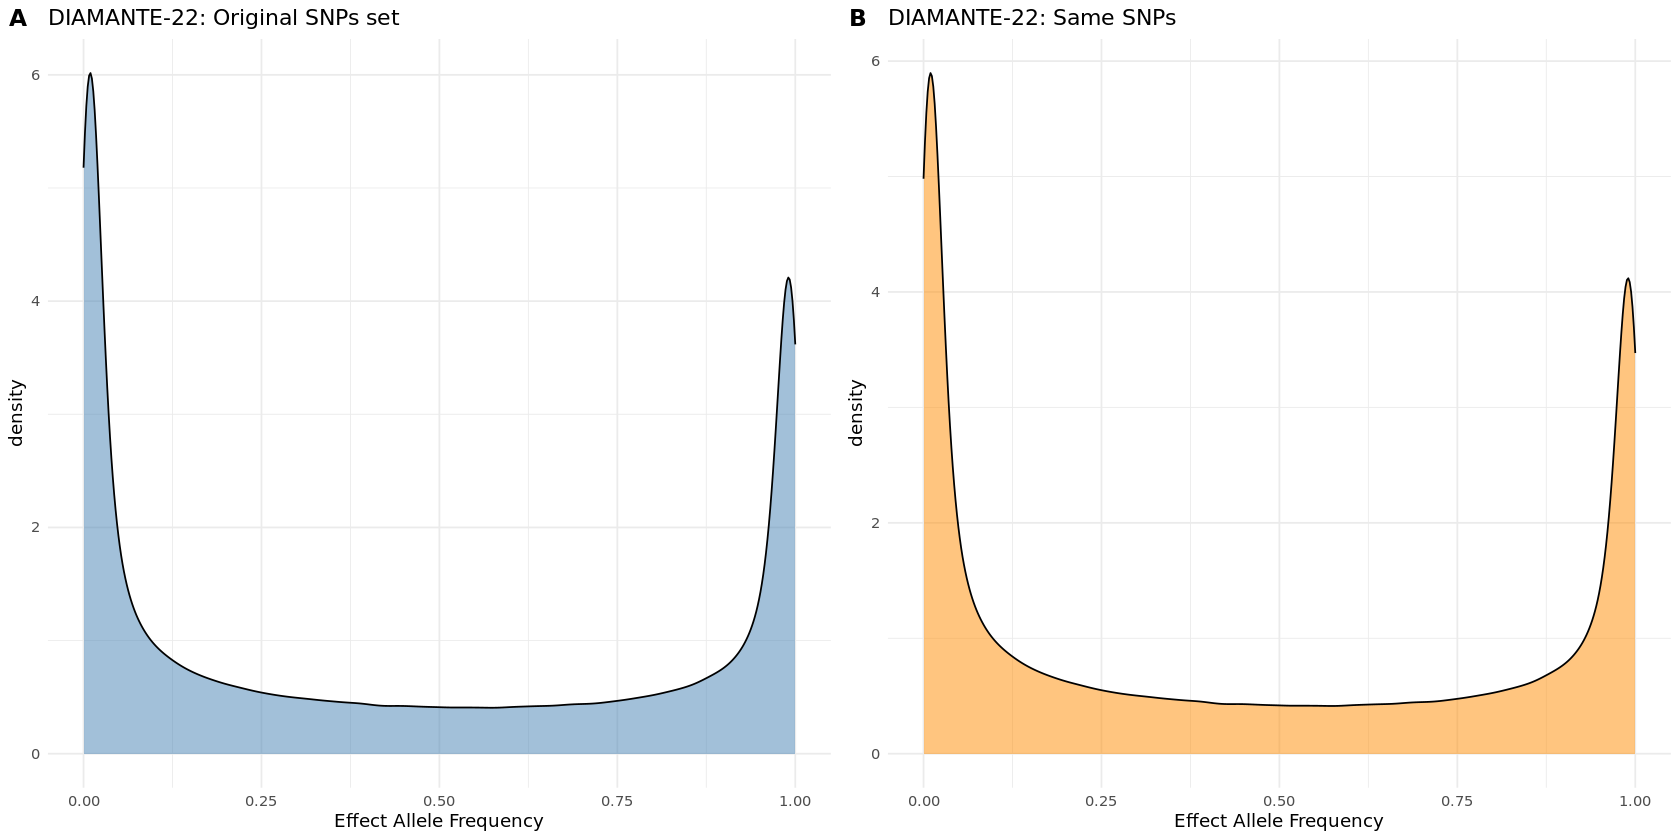

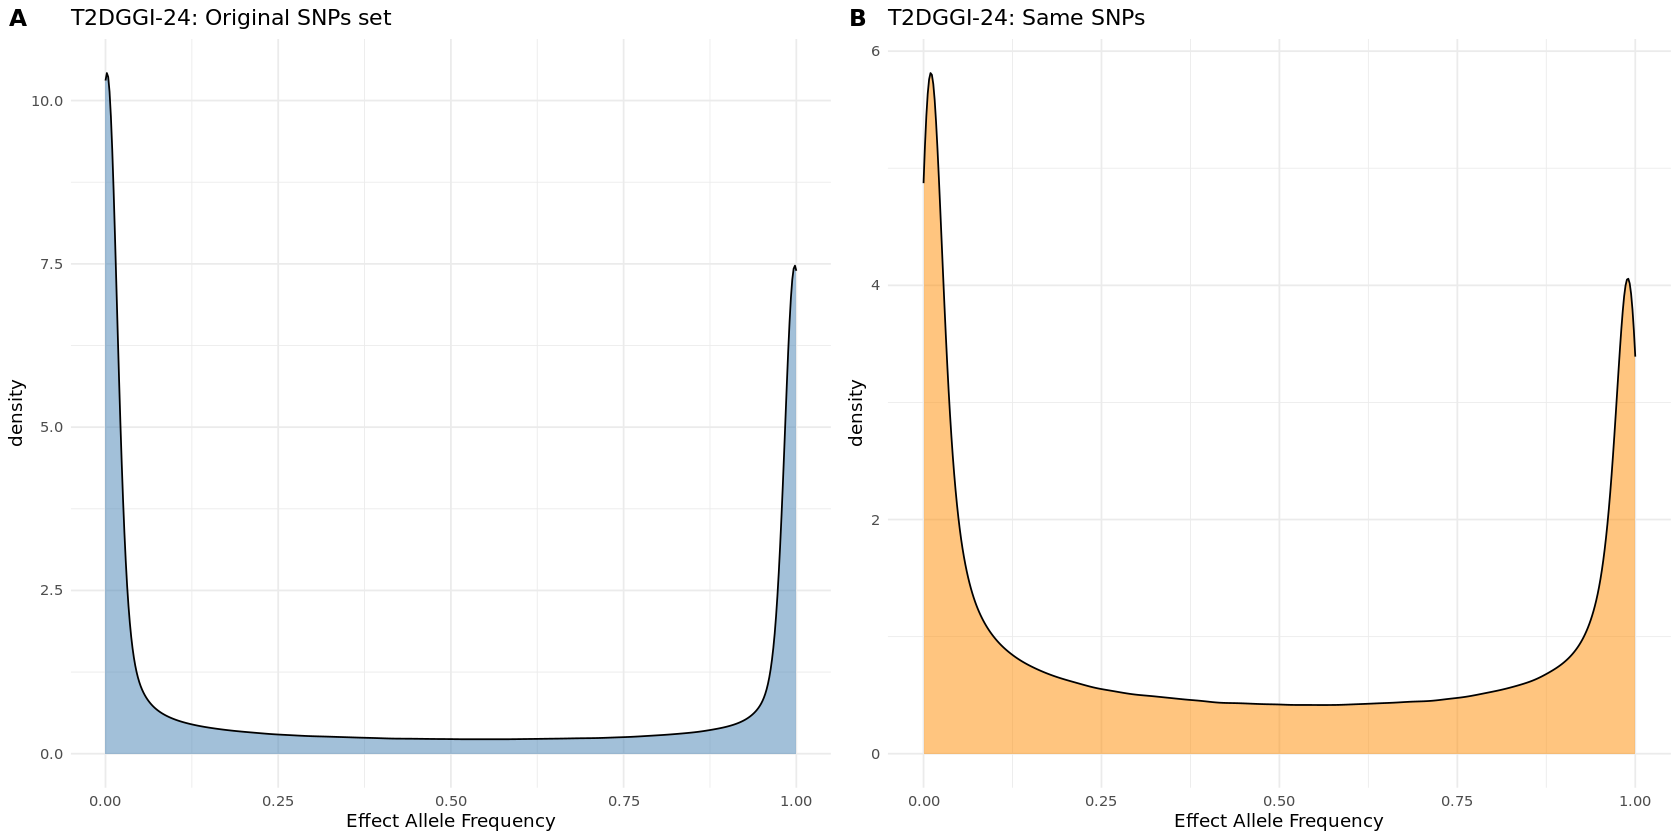

In [12]:
#DIAMANTE-22
p1 <- ggplot(diamante22, aes(x = effect_allele_frequency)) +
  geom_density(fill = "steelblue", alpha = 0.5) +
  ggtitle("DIAMANTE-22: Original SNPs set") +
  labs(x = "Effect Allele Frequency") +
  #xlim(0, 0.5) +
  theme_minimal()

# Plot 2
p2 <- ggplot(diam22, aes(x = effect_allele_frequency)) +
  geom_density(fill = "darkorange", alpha = 0.5) +
  ggtitle("DIAMANTE-22: Same SNPs") +
  labs(x = "Effect Allele Frequency") +
  #xlim(0, 0.5) +
  theme_minimal()

# Combine side-by-side with shared main title
options(repr.plot.width = 14, repr.plot.height =7) 
plot_2 <- ggarrange(p1, p2, labels = c("A", "B"))
plot_2

#T2DGGI-24
p1 <- ggplot(t2dggi, aes(x = Freq1)) +
  geom_density(fill = "steelblue", alpha = 0.5) +
  ggtitle("T2DGGI-24: Original SNPs set") +
  labs(x = "Effect Allele Frequency") +
  theme_minimal()

# Plot 2
p2 <- ggplot(t2dggi24, aes(x = Freq1)) +
  geom_density(fill = "darkorange", alpha = 0.5) +
  ggtitle("T2DGGI-24: Same SNPs") +
  labs(x = "Effect Allele Frequency") +
  theme_minimal()

# Combine side-by-side with shared main title
options(repr.plot.width = 14, repr.plot.height =7) 
plot_2 <- ggarrange(p1, p2, labels = c("A", "B"))
plot_2

In [57]:
# Checking median of the test stats distribution in DIAMANTE-18, 22 and T2DGGI-24
#DIAMANTE-18
chisq <- qchisq(as.numeric(diamante18$Pvalue),1,lower.tail=FALSE)
lambda2 <- c(1.013)
newchisq <- chisq*lambda2
newpvalues <- pchisq(newchisq, df=1,lower.tail=FALSE)
diamante18$single_gc_p_values <- newpvalues
chisq <- qchisq(as.numeric(diamante18$single_gc_p_values),1,lower.tail=FALSE)
median(chisq)

chisq <- qchisq(as.numeric(diam18$Pvalue),1,lower.tail=FALSE)
lambda2 <- c(1.013)
newchisq <- chisq*lambda2
newpvalues <- pchisq(newchisq, df=1,lower.tail=FALSE)
diam18$single_gc_p_values <- newpvalues
chisq <- qchisq(as.numeric(diam18$single_gc_p_values),1,lower.tail=FALSE)
median(chisq)

#DIAMANTE-22
chisq <- qchisq(as.numeric(diamante22$`Fixed-effects_p-value`),1,lower.tail=FALSE)
lambda2 <- c(1.096) 
newchisq <- chisq*lambda2
newpvalues <- pchisq(newchisq, df=1,lower.tail=FALSE)
diamante22$single_gc_p_values <- newpvalues
chisq <- qchisq(as.numeric(diamante22$single_gc_p_values),1,lower.tail=FALSE)
median(chisq)

chisq <- qchisq(as.numeric(diam22$`Fixed-effects_p-value`),1,lower.tail=FALSE)
lambda2 <- c(1.096) 
newchisq <- chisq*lambda2
newpvalues <- pchisq(newchisq, df=1,lower.tail=FALSE)
diam22$single_gc_p_values <- newpvalues
chisq <- qchisq(as.numeric(diam22$single_gc_p_values),1,lower.tail=FALSE)
median(chisq)

#T2DGGI-24
#T2DGGI
chisq <- qchisq(as.numeric(t2dggi$`P-value`),1,lower.tail=FALSE)
median(chisq)

chisq <- qchisq(as.numeric(t2dggi24$`P-value`),1,lower.tail=FALSE)
median(chisq)

[1] 0.5287617

[1] 0.6309202

[1] 0.6293087

[1] 0.6376742

[1] 0.5841249

[1] 0.7626515

In [8]:
#for LD-clumpping
diamante_22_tmp <- diamante22
# Transform the 'id' column
diamante_22_tmp <- diamante22 %>%
  mutate(
    id = gsub("^chr", "", id),                           # Remove "chr"
    id = gsub(":(\\w):(\\w)$", ":\\U\\2:\\U\\1", id, perl = TRUE) # Flip alleles and convert to uppercase
  )
diamante_22_tmp <- diamante_22_tmp %>% rename(SNP = id)
fwrite(diamante_22_tmp, "/lustre/groups/itg/teams/zeggini/users/archit.singh/lambda/summary_statistics/T2D/Mahajan.NatGen2022.DIAMANTE-EUR.sumstat/DIAMANTE-EUR.sumstat_for_LD_clumpping.txt", sep = "\t")

In [13]:
#filtering out rows that are same across the three datasets
common_rows <- diamante18 %>%
  inner_join(diamante22, by = "id") %>%
  inner_join(t2dggi, by = "id")
dim(common_rows)
diamante18 <- semi_join(diamante18, common_rows, by = "id")
diamante22 <- semi_join(diamante22, common_rows, by = "id")
t2dggi <- semi_join(t2dggi, common_rows, by = "id")

[1] 10269674       36

In [13]:
#for polygenicity estimate analysis
#getting corresponding rsIDs for variants in the T2DGGI-EUR summary stats
t2dggi_tmp <- t2dggi %>%
  inner_join(diamante22, by = "id") %>%
  select(id, rsID, `P-value`)
fwrite(t2dggi_tmp, "/lustre/groups/itg/teams/zeggini/users/archit.singh/lambda/summary_statistics/T2D/T2DGGI/t2dggi_EUR_only_rsids_and_pvalue.txt", sep = "\t")

In [14]:
#calculating GC-lambda for each meta-analysis summary stats
#DIAMANTE-18
chisq <- qchisq(as.numeric(diamante18$Pvalue),1,lower.tail=FALSE)
lambda2 <- c(1.013)
newchisq <- chisq*lambda2
newpvalues <- pchisq(newchisq, df=1,lower.tail=FALSE)
diamante18$single_gc_p_values <- newpvalues
chisq <- qchisq(as.numeric(diamante18$single_gc_p_values),1,lower.tail=FALSE)
lambda1 <- median(chisq)/qchisq(0.5,1)
print(lambda1)
lambda1 <- round(lambda1, digits = 3)

#DIAMANTE-22
chisq <- qchisq(as.numeric(diamante22$`Fixed-effects_p-value`),1,lower.tail=FALSE)
lambda2 <- c(1.096) 
newchisq <- chisq*lambda2
newpvalues <- pchisq(newchisq, df=1,lower.tail=FALSE)
diamante22$single_gc_p_values <- newpvalues
chisq <- qchisq(as.numeric(diamante22$single_gc_p_values),1,lower.tail=FALSE)
lambda2 <- median(chisq)/qchisq(0.5,1)
print(lambda2)
lambda2 <- round(lambda2, digits = 3)

#T2DGGI
chisq <- qchisq(as.numeric(t2dggi$`P-value`),1,lower.tail=FALSE)
lambda3 <- median(chisq)/qchisq(0.5,1)
print(lambda3)
lambda3 <- round(lambda3, digits = 3)

[1] 1.386832
[1] 1.401678
[1] 1.676391


In [15]:
#getting the number of GWS-associations in the three datasets
dim(subset(diamante18, as.numeric(diamante18$single_gc_p_values) <= 0.00000005))
dim(subset(diamante22, as.numeric(diamante22$single_gc_p_values) <= 0.00000005))
dim(subset(t2dggi, as.numeric(t2dggi$`P-value`) <= 0.00000005))

[1] 19328    12

[1] 20925    12

[1] 64944    16

In [10]:
#creatig files for LD score regression for summary stats with different MAF cutoff
diamante18_tmp <- diamante18 %>%
  inner_join(diamante22 %>% select(id, rsID), by = "id")

t2dggi_tmp <- t2dggi %>%
  inner_join(diamante22 %>% select(id, rsID), by = "id")

# Storing datasets in a list
diamante18_comm <- diamante18_tmp
diamante22_comm <- diamante22
t2dggi_comm <- t2dggi_tmp

# Synchronizing column names
names(diamante18_comm) <- sub("EAF", "MAF", names(diamante18_comm))
names(diamante22_comm) <- sub("effect_allele_frequency", "MAF", names(diamante22_comm))
names(t2dggi_comm) <- sub("Freq1", "MAF", names(t2dggi_comm))

# Add names to the summary stats list
summary_stats_list <- list(
  diamante18_comm = diamante18_comm,
  diamante22_comm = diamante22_comm,
  t2dggi_comm = t2dggi_comm
)

# Thresholds for filtering
thresholds <- c(0, 0.005, 0.01, 0.05, 0.1)

# Path to save filtered files
output_path <- "/lustre/groups/itg/teams/zeggini/users/archit.singh/lambda/LDSR_intercept_MAF_stratified/"

# Iterate through each summary stats dataset
for (i in seq_along(summary_stats_list)) {
  stats <- summary_stats_list[[i]]
  stats_name <- names(summary_stats_list)[i]
  
  for (threshold in thresholds) {
    # Filter summary stats based on MAF threshold
    filtered_stats <- stats %>% filter(!is.na(MAF) & as.numeric(MAF) > threshold)
    
    # Construct output file name
    output_file <- file.path(output_path, paste0(stats_name, "_MAF_", threshold, ".txt"))
    
    # Write filtered stats to a tab-separated file
    fwrite(filtered_stats, output_file, sep = "\t")
  }
}

#saving summary statistics for use in the LDSR analysis
fwrite(diamante18, "/lustre/groups/itg/teams/zeggini/users/archit.singh/lambda/summary_statistics/T2D/Mahajan.NatGenet2018b.T2D.European.undajusted.BMI/same_variants_DIAMANTE_18.txt", sep = "\t")
fwrite(diamante22, "/lustre/groups/itg/teams/zeggini/users/archit.singh/lambda/summary_statistics/T2D/Mahajan.NatGen2022.DIAMANTE-EUR.sumstat/same_variants_DIAMANTE_22.txt", sep = "\t")
fwrite(t2dggi, "/lustre/groups/itg/teams/zeggini/users/archit.singh/lambda/summary_statistics/T2D/T2DGGI/same_variants_T2DGGI_24.txt", sep = "\t")

In [16]:
#calculating effective sample size
#DIAMANTE-18
cases <- c(74124)
ctrls <- c(824006)
neffective_diamante18 <- c(4/((1/cases) + (1/ctrls)))
#DIAMANTE-22
cases <- c(80154)
ctrls <- c(853816)
neffective_diamante22 <- c(4/((1/cases) + (1/ctrls)))
#T2DGGI-24
cases <- c(242283)
ctrls <- c(1569734)
neffective_t2dggi <- c(4/((1/cases) + (1/ctrls)))

In [17]:
#plotting proportion of rare variants vs. lambda values
#calculating proportion of rare variants
rare_diamante18 <- subset(diamante18, diamante18$EAF < 0.01)
proportion_diamante18 <- (length(rare_diamante18$id)/length(diamante18$id))*100
rare_diamante22 <- subset(diamante22, diamante22$effect_allele_frequency < 0.01)
proportion_diamante22 <- (length(rare_diamante22$id)/length(diamante22$id))*100
rare_t2dggi <- subset(t2dggi, t2dggi$Freq1 < 0.01)
proportion_t2dggi <- (length(rare_t2dggi$id)/length(t2dggi$id))*100
proportion_diamante18
proportion_diamante22
proportion_t2dggi

#calculating proportion of common variants
common_diamante18 <- subset(diamante18, diamante18$EAF > 0.05)
proportion_diamante18 <- (length(common_diamante18$id)/length(diamante18$id))*100
common_diamante22 <- subset(diamante22, diamante22$effect_allele_frequency > 0.05)
proportion_diamante22 <- (length(common_diamante22$id)/length(diamante22$id))*100
common_t2dggi <- subset(t2dggi, t2dggi$Freq1 > 0.05)
proportion_t2dggi <- (length(common_t2dggi$id)/length(t2dggi$id))*100
proportion_diamante18
proportion_diamante22
proportion_t2dggi

[1] 13.76636

[1] 13.65975

[1] 13.25961

[1] 72.017

[1] 72.10964

[1] 72.29971

lambda_val,studies,sample_size,effective_sample_sizes,total_variants
<dbl>,<fct>,<fct>,<dbl>,<fct>
1.387,DIAMANTE-18,898K,12.51,10M
1.402,DIAMANTE-22,933K,12.59,10M
1.676,T2DGGI-24,1.8M,13.64,10M


Warning message:
“The `show_guide` argument of `layer()` is deprecated as of ggplot2 2.0.0.
ℹ Please use the `show.legend` argument instead.”


png 
  2

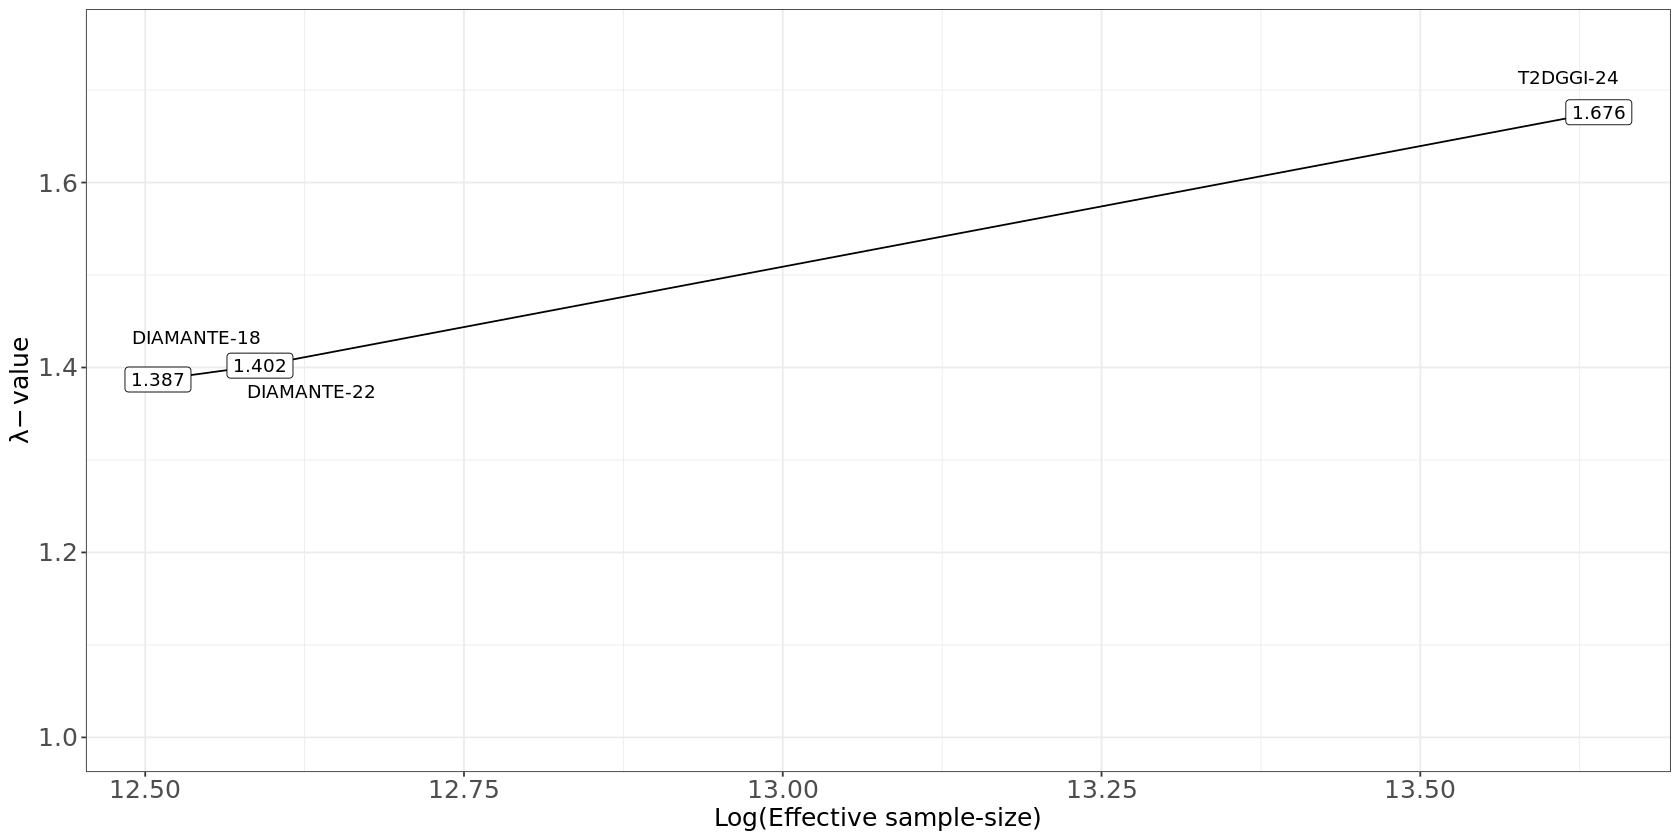

In [18]:
#plotting lambda values for studies
#including same variants across the 3 studies
lambda_val <- c(lambda1, lambda2, lambda3)
studies <- c("DIAMANTE-18", "DIAMANTE-22", "T2DGGI-24")
sample_size <- c("898K", "933K", "1.8M")
total_variants <- c("10M", "10M", "10M")
effective_sample_sizes <- c(neffective_diamante18, neffective_diamante22, neffective_t2dggi)
effective_sample_sizes <- round(log(effective_sample_sizes), digits = 2)
df.plot <- data.frame(lambda_val, studies, sample_size, effective_sample_sizes, total_variants)
df.plot$sample_size <- factor(df.plot$sample_size, levels=c("898K", "933K", "1.8M"))
#df.plot$effective_sample_size <- factor(df.plot$effective_sample_size, levels=c(effective_sample_size[1], effective_sample_size[2], effective_sample_size[3], effective_sample_size[4]))
df.plot$total_variants <- factor(df.plot$total_variants, levels=c("10M"))
df.plot$studies <- factor(df.plot$studies, levels=c("DIAMANTE-18", "DIAMANTE-22", "T2DGGI-24"))
df.plot
ggplot(data=df.plot, aes(x=effective_sample_sizes, y=lambda_val, group=1)) + 
  xlab("Log(Effective sample-size)") + ylab(expression(lambda*-value)) +
  geom_line(color="black") +
  geom_point() + geom_text(data=subset(df.plot, effective_sample_sizes == 12.51 | lambda_val == 1.387), aes(effective_sample_sizes,lambda_val,label=studies), hjust=0.2, vjust=-2.7) + geom_text(data=subset(df.plot, effective_sample_sizes == 12.59 | lambda_val == 1.402), aes(effective_sample_sizes,lambda_val,label=studies), hjust=0.1, vjust=2.5) + geom_text(data=subset(df.plot, effective_sample_sizes == 13.64 | lambda_val == 1.676), aes(effective_sample_sizes,lambda_val,label=studies), hjust=0.8, vjust=-2.2) +  geom_label(aes(label = lambda_val), show_guide = F) + ylim(1,1.75) + theme_bw() +
  theme(plot.title = element_text(size=20), axis.text = element_text(size = 15), legend.position = c(0.70, 0.90), legend.text = element_text(size = 15), legend.title = element_blank(), axis.title = element_text(size = 15), legend.key = element_blank(), legend.background = element_blank())

plot22 <- ggplot(data=df.plot, aes(x=effective_sample_sizes, y=lambda_val, group=1)) + 
  xlab("Log(Effective sample-size)") + ylab(expression(lambda*-value)) +
  geom_line(color="black") +
  geom_point() + geom_text(data=subset(df.plot, effective_sample_sizes == 12.51 | lambda_val == 1.387), aes(effective_sample_sizes,lambda_val,label=studies), hjust=0.2, vjust=-2.7) + geom_text(data=subset(df.plot, effective_sample_sizes == 12.59 | lambda_val == 1.402), aes(effective_sample_sizes,lambda_val,label=studies), hjust=0.1, vjust=2.5) + geom_text(data=subset(df.plot, effective_sample_sizes == 13.64 | lambda_val == 1.676), aes(effective_sample_sizes,lambda_val,label=studies), hjust=0.8, vjust=-2.2) +  geom_label(aes(label = lambda_val), show_guide = F) + ylim(1,1.75) + theme_bw() +
  theme(plot.title = element_text(size=20), axis.text = element_text(size = 15), legend.position = c(0.70, 0.90), legend.text = element_text(size = 15), legend.title = element_blank(), axis.title = element_text(size = 15), legend.key = element_blank(), legend.background = element_blank())
#saving plot as .pdf
#pdf("/lustre/groups/itg/teams/zeggini/users/archit.singh/lambda/plots_for_manuscript/supplementary_figure_2.pdf")
#print(plot22)     # Plot 1 --> in the first page of PDF
#dev.off()
#png("/lustre/groups/itg/teams/zeggini/users/archit.singh/lambda/plots_for_manuscript/supplementary_figure_2.png")
#print(plot22)     # Plot 1 --> in the first page of PDF
#dev.off()
#combining figures
#options(repr.plot.width = 14, repr.plot.height =7) 
#plot_s2 <- ggarrange(plot1, plot22, labels = c("A", "B"))
ggsave(plot22, filename = "/lustre/groups/itg/teams/zeggini/users/archit.singh/lambda/plots_for_manuscript/supplementary_figure_2.pdf", width=14, height=7, units="in")
jpeg(filename = "/lustre/groups/itg/teams/zeggini/users/archit.singh/lambda/plots_for_manuscript/supplementary_figure_2.jpeg", width = 10, height = 6, units = "in", res = 400)
print(plot22)
dev.off()

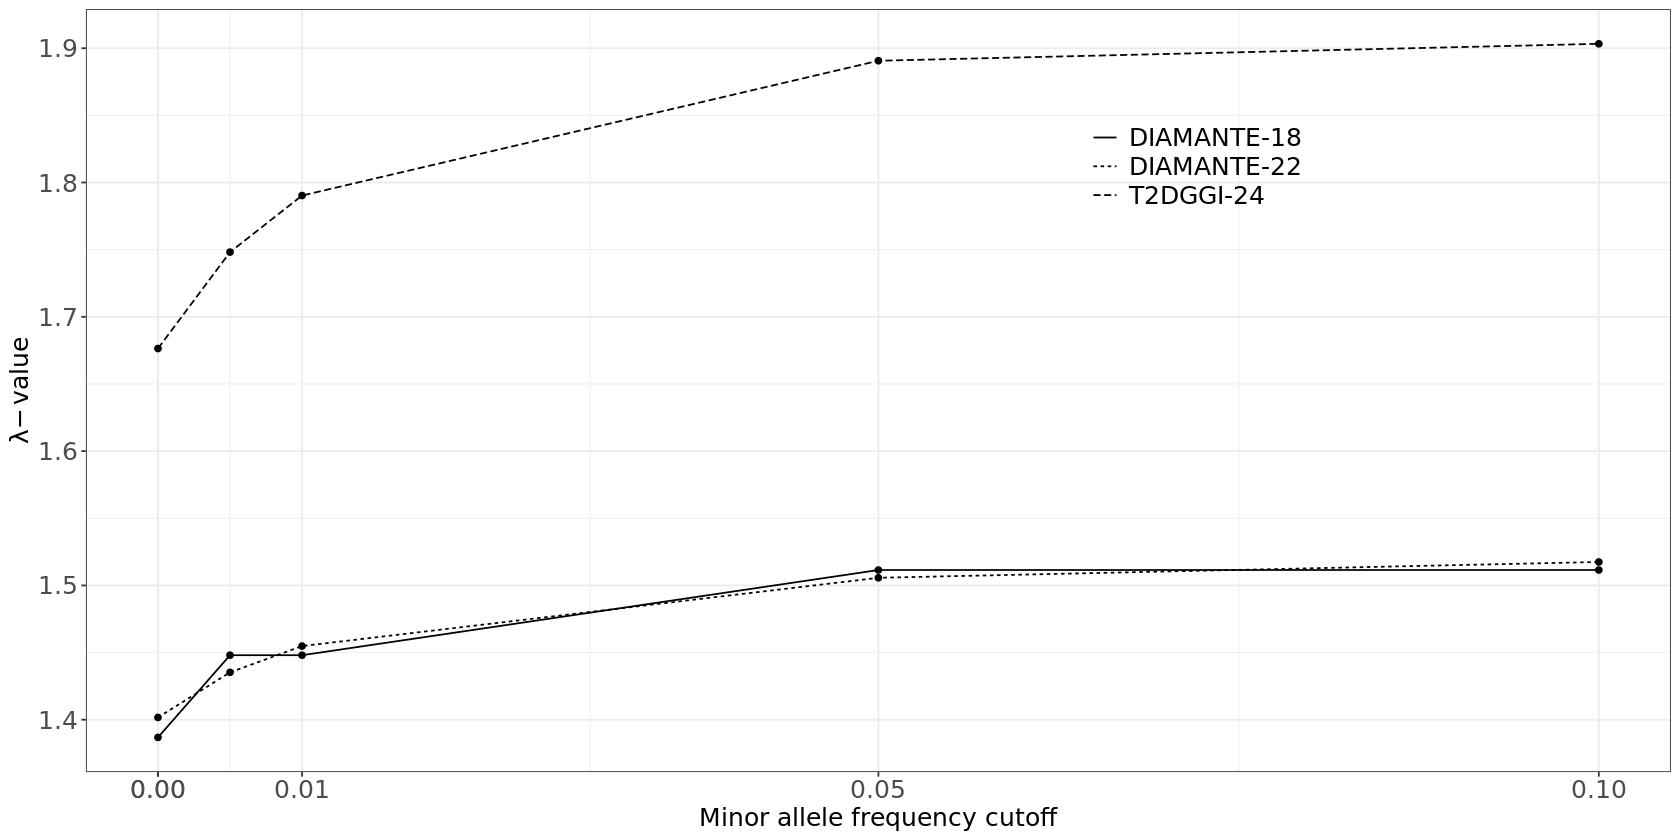

png 
  2

png 
  2

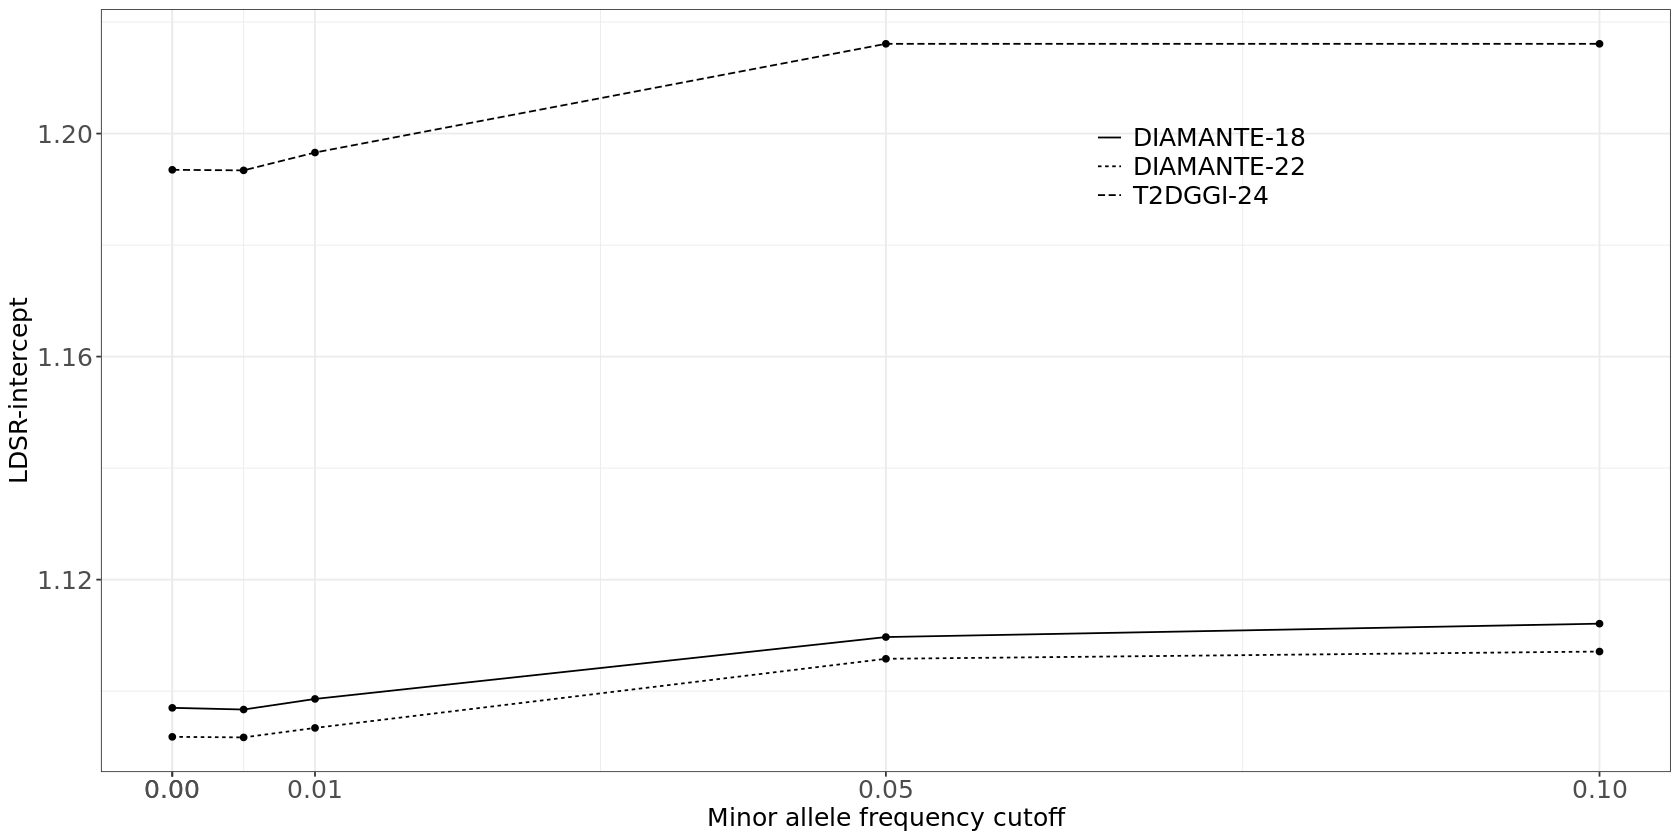

In [19]:
#Analysing same variants in each study and observing effect of MAF cutoff on lambda
#storing datasets in a list
diamante18_comm <- diamante18
diamante22_comm <- diamante22
t2dggi_comm <- t2dggi
#synchronising names of columns
names(diamante18_comm)[names(diamante18_comm) == "EAF"] <- "MAF"
names(diamante22_comm)[names(diamante22_comm) == "effect_allele_frequency"] <- "MAF"
names(t2dggi_comm)[names(t2dggi_comm) == "Freq1"] <- "MAF"
names(t2dggi_comm)[names(t2dggi_comm) == "P-value"] <- "single_gc_p_values"
#creating function to calculate lambda value
calculate_lambda <- function(p_values) {
  chisq <- qchisq(as.numeric(p_values),1,lower.tail=FALSE)
  return(median(chisq)/qchisq(0.5,1))
}
summary_stats_list <- list(diamante18_comm, diamante22_comm, t2dggi_comm)
thresholds <- c(0, 0.005, 0.01, 0.05, 0.1)
lambda_values <- c()
#for each summary stats, firstly filtering based on MAF threshold and then calculating lambda value
for (i in 1:length(summary_stats_list)) {
  stats <- summary_stats_list[[i]]
  #lambda_values[[i]] <- c()
  for (threshold in thresholds) {
    filtered_stats <- stats %>% filter(as.numeric(MAF) > threshold)
    lambda <- calculate_lambda(filtered_stats$single_gc_p_values)
    lambda_values <- c(lambda_values, lambda)
  }
}

#plotting results
MAF <- c(0, 0.005, 0.01, 0.05, 0.1, 0, 0.005, 0.01, 0.05, 0.1, 0, 0.005, 0.01, 0.05, 0.1)
study <- c("DIAMANTE-18", "DIAMANTE-18", "DIAMANTE-18", "DIAMANTE-18", "DIAMANTE-18", "DIAMANTE-22", "DIAMANTE-22", "DIAMANTE-22", "DIAMANTE-22", "DIAMANTE-22", "T2DGGI-24", "T2DGGI-24", "T2DGGI-24", "T2DGGI-24", "T2DGGI-24")
ldsr_intercept <- c(1.097, 1.0967, 1.0986, 1.1097, 1.1121, 1.0918, 1.0917, 1.0934, 1.1058, 1.1071, 1.1935, 1.1934, 1.1966, 1.2161, 1.2161)
df.plot <- data.frame(lambda_values, ldsr_intercept, MAF, study)
plot3 <- ggplot(df.plot, aes(x=MAF, y=lambda_values, linetype=study)) + geom_point() + scale_x_continuous(breaks = round(c(0, 0.005, 0.01, 0.05, 0.1),2)) +
 geom_line(aes(linetype=study, group = study)) + xlab("Minor allele frequency cutoff") + ylab(expression(lambda*-value)) + theme_bw() +
  theme(axis.text = element_text(size = 15), legend.position = c(0.70, 0.80), legend.text = element_text(size = 15), legend.title = element_blank(), axis.title = element_text(size = 15), legend.key = element_blank(), legend.background = element_blank())
#for GC
ggplot(df.plot, aes(x=MAF, y=lambda_values, linetype=study)) + geom_point() + scale_x_continuous(breaks = round(c(0, 0.005, 0.01, 0.05, 0.1),2)) +
 geom_line(aes(linetype=study, group = study)) + xlab("Minor allele frequency cutoff") + ylab(expression(lambda*-value)) + theme_bw() +
  theme(axis.text = element_text(size = 15), legend.position = c(0.70, 0.80), legend.text = element_text(size = 15), legend.title = element_blank(), axis.title = element_text(size = 15), legend.key = element_blank(), legend.background = element_blank())
#for LDSR-intercept
ggplot(df.plot, aes(x=MAF, y=ldsr_intercept, linetype=study)) + geom_point() + scale_x_continuous(breaks = round(c(0, 0.005, 0.01, 0.05, 0.1),2)) + #ylim(1, 1.9) +
 geom_line(aes(linetype=study, group = study)) + xlab("Minor allele frequency cutoff") + ylab("LDSR-intercept") + theme_bw() +
  theme(axis.text = element_text(size = 15), legend.position = c(0.70, 0.80), legend.text = element_text(size = 15), legend.title = element_blank(), axis.title = element_text(size = 15), legend.key = element_blank(), legend.background = element_blank())
#save plot as .jpeg
jpeg(filename = "/lustre/groups/itg/teams/zeggini/users/archit.singh/lambda/plots_for_manuscript/supplementary_figure_3.jpeg", width = 10, height = 6, units = "in", res = 400)
print(plot3)
dev.off()
#saving plot as .pdf
pdf("/lustre/groups/itg/teams/zeggini/users/archit.singh/lambda/plots_for_manuscript/supplementary_figure_3.pdf")
print(plot3)
dev.off() 

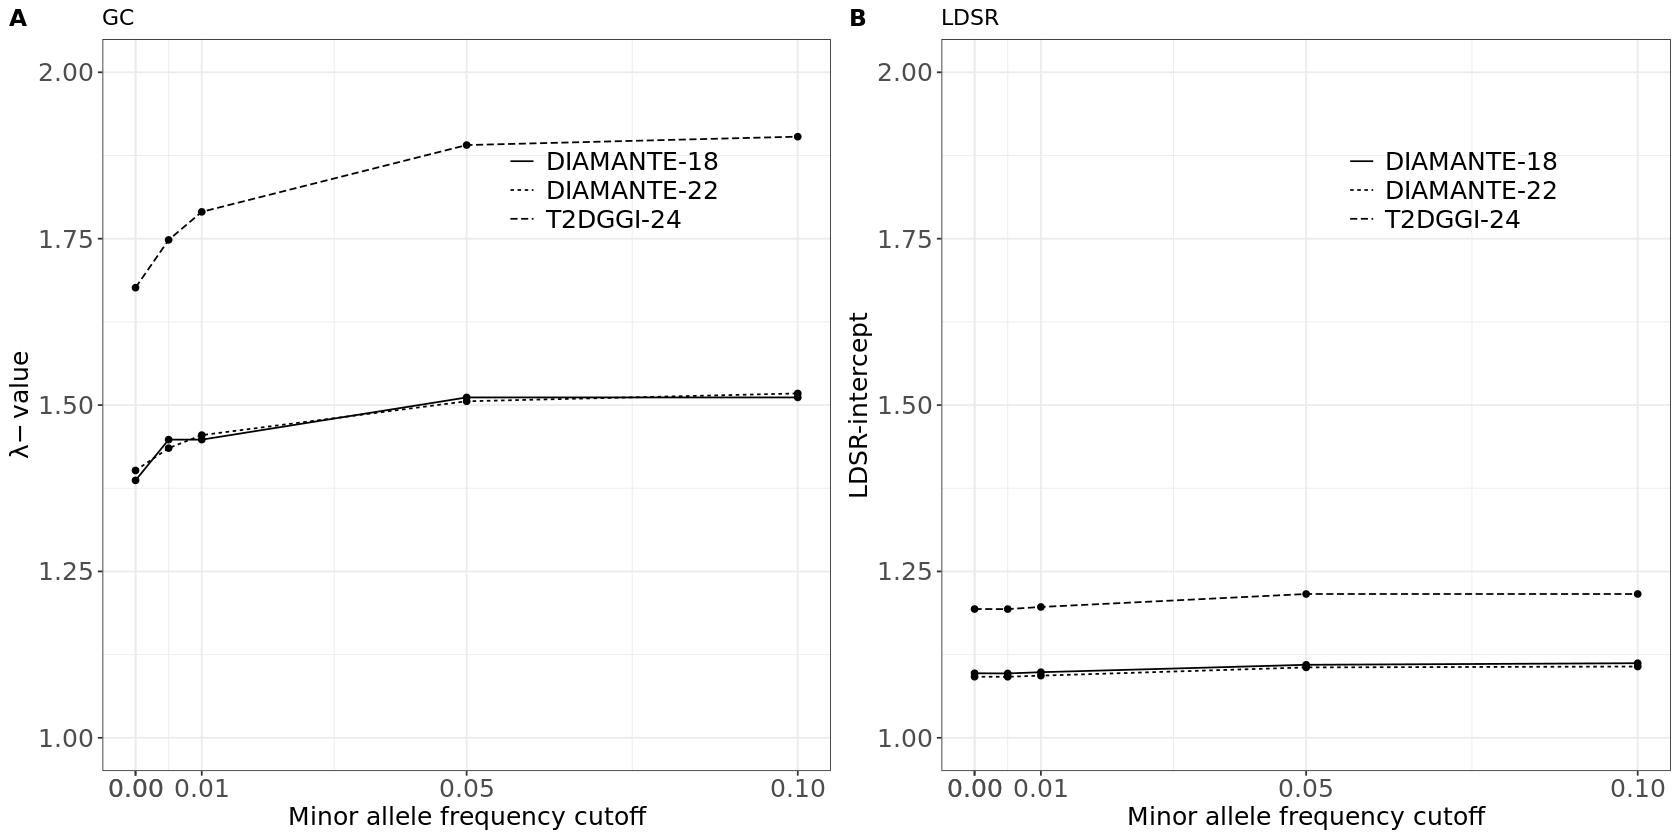

In [12]:
#for LDSR-intercept
plot_ldsr <- ggplot(df.plot, aes(x=MAF, y=ldsr_intercept, linetype=study)) + geom_point() + scale_x_continuous(breaks = round(c(0, 0.005, 0.01, 0.05, 0.1),2)) + ylim(1, 2) + ggtitle("LDSR") +
 geom_line(aes(linetype=study, group = study)) + xlab("Minor allele frequency cutoff") + ylab("LDSR-intercept") + theme_bw() +
  theme(axis.text = element_text(size = 15), legend.position = c(0.70, 0.80), legend.text = element_text(size = 15), legend.title = element_blank(), axis.title = element_text(size = 15), legend.key = element_blank(), legend.background = element_blank())

#for GC
plot_gc <- ggplot(df.plot, aes(x=MAF, y=lambda_values, linetype=study)) + geom_point() + scale_x_continuous(breaks = round(c(0, 0.005, 0.01, 0.05, 0.1),2)) + ylim(1, 2) + ggtitle("GC") +
 geom_line(aes(linetype=study, group = study)) + xlab("Minor allele frequency cutoff") + ylab(expression(lambda*-value)) + theme_bw() +
  theme(axis.text = element_text(size = 15), legend.position = c(0.70, 0.80), legend.text = element_text(size = 15), legend.title = element_blank(), axis.title = element_text(size = 15), legend.key = element_blank(), legend.background = element_blank())

#combining figures
options(repr.plot.width = 14, repr.plot.height =7) 
plot_2 <- ggarrange(plot_gc, plot_ldsr, labels = c("A", "B"))
plot_2

In [20]:
#finding variants analysed commonly between datasets
diamante18_snps <- data.frame(diamante18$id)
colnames(diamante18_snps) <- c("id")
diamante22_snps <- data.frame(diamante22$id)
colnames(diamante22_snps) <- c("id")
t2dggi_snps <- data.frame(t2dggi$id)
colnames(t2dggi_snps) <- c("id")
dataset_list_1 <- list(diamante18_snps, diamante22_snps)
dataset_list_2 <- list(diamante18_snps, t2dggi_snps)
dataset_list_3 <- list(diamante22_snps, t2dggi_snps)
comm_snps_1 <- reduce(dataset_list_1, inner_join)
comm_snps_2 <- reduce(dataset_list_2, inner_join)
comm_snps_3 <- reduce(dataset_list_3, inner_join)

Joining with `by = join_by(id)`
Joining with `by = join_by(id)`
Joining with `by = join_by(id)`


In [21]:
#adding another column indicating direction of effect (1 for positive beta, 0 for negative beta)
#this is for further analysis
diamante18$direction_of_effect <- rep(1, length(diamante18$id))
diamante18$direction_of_effect[diamante18$Beta < 0] <- 0
diamante22$direction_of_effect <- rep(1, length(diamante22$id))
diamante22$direction_of_effect[diamante22$`Fixed-effects_beta` < 0] <- 0
t2dggi$direction_of_effect <- rep(1, length(t2dggi$id))
t2dggi$direction_of_effect[t2dggi$Effect < 0] <- 0

#correcting the p-values with the new lambda values; check jupyter notebook titled "getting_variants_with_MAF_morethan_0.005"
#DIAMANTE-18
chisq <- qchisq(as.numeric(diamante18$single_gc_p_values),1,lower.tail=FALSE)
lambda <- c(1.387) #rounding off to 3 digits after decimal point
newchisq <- chisq/lambda
newpvalues <- pchisq(newchisq, df=1,lower.tail=FALSE)
diamante18$double_gc_p_values <- newpvalues

#DIAMANTE-22
chisq <- qchisq(as.numeric(diamante22$single_gc_p_values),1,lower.tail=FALSE)
lambda <- c(1.402) 
newchisq <- chisq/lambda
newpvalues <- pchisq(newchisq, df=1,lower.tail=FALSE)
diamante22$double_gc_p_values <- newpvalues

In [15]:
head(diamante18)
head(diamante22)
head(t2dggi)

SNP,Chr,Pos,EA,NEA,EAF,Beta,SE,Pvalue,Neff,id,single_gc_p_values,direction_of_effect,double_gc_p_values
<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>
1:100000012,1,100000012,t,g,0.2500,-0.0260,0.0073,4.0e-04,231420,chr1:100000012:t:g,0.0003666127,0,0.002483203
1:10000006,1,10000006,a,g,0.0047,-0.0380,0.0560,4.9e-01,225429,chr1:10000006:a:g,0.4871923423,0,0.555228988
1:100000827,1,100000827,t,c,0.3000,-0.0230,0.0069,7.5e-04,231420,chr1:100000827:t:c,0.0006926919,0,0.003969778
1:100000843,1,100000843,t,c,0.9400,0.0006,0.0140,9.7e-01,231420,chr1:100000843:t:c,0.9698057222,1,0.974360158
1:100001138,1,100001138,a,g,0.9700,-0.0041,0.0220,8.6e-01,230619,chr1:100001138:a:g,0.8591023957,0,0.880188224
1:100001201,1,100001201,t,g,0.1000,-0.0170,0.0099,8.9e-02,231420,chr1:100001201:t:g,0.0869491490,0,0.146105163


chromosome(b37),position(b37),chrposID,rsID,effect_allele,other_allele,effect_allele_frequency,Fixed-effects_beta,Fixed-effects_SE,Fixed-effects_p-value,id,single_gc_p_values,direction_of_effect,double_gc_p_values
<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,693731,chr1:693731,rs12238997,a,g,0.8747,0.0044,0.0119,0.7124,chr1:693731:a:g,0.6995531,1,0.7444755
1,706368,chr1:706368,rs55727773,a,g,0.4964,0.0118,0.0099,0.2355,chr1:706368:a:g,0.2142558,1,0.2942294
1,721290,chr1:721290,rs12565286,c,g,0.0359,-0.0176,0.0262,0.5013,chr1:721290:c:g,0.4814430,0,0.5521442
1,729679,chr1:729679,rs4951859,c,g,0.1656,-0.0043,0.0105,0.6813,chr1:729679:c:g,0.6672311,0,0.7165184
1,730087,chr1:730087,rs148120343,t,c,0.9409,0.0001,0.0172,0.9954,chr1:730087:t:c,0.9951843,1,0.9959329
1,731718,chr1:731718,rs142557973,t,c,0.8694,0.0088,0.0111,0.4278,chr1:731718:t:c,0.4064529,1,0.4832369


MarkerName,Allele1,Allele2,Freq1,FreqSE,MinFreq,MaxFreq,Effect,StdErr,P-value,Direction,HetISq,HetChiSq,HetDf,HetPVal,id,direction_of_effect
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<dbl>
chr11:88249377,t,c,0.9921,0.0018,0.9881,0.9972,-0.0337,0.0214,0.1146,---++--+-+---+-+++-----+++-+------++,25.7,47.089,35,0.08327,chr11:88249377:t:c,0
chr8:135908647,a,g,0.2034,0.0176,0.1449,0.2956,-0.0020,0.0046,0.6633,++-+-+---+++--+---------++-++++--+++,20.1,43.801,35,0.14620,chr8:135908647:a:g,0
chr12:3871714,a,c,0.9979,0.0009,0.9973,1.0000,-0.0678,0.0918,0.4603,--??+??-+??????????-+--???-??????-??,0.0,9.532,10,0.48250,chr12:3871714:a:c,0
chr11:97895884,c,g,0.0554,0.0061,0.0369,0.0828,0.0215,0.0081,0.007924,+++-++++-+-+--++-+----++-++--+++++-+,3.0,36.087,35,0.41750,chr11:97895884:c:g,1
chr7:8327736,a,t,0.9940,0.0027,0.9921,1.0000,0.0055,0.0454,0.9032,-++?-+?--+?-???--??+--++??-?????+--?,0.0,9.576,19,0.96260,chr7:8327736:a:t,1
chr18:814730,c,g,0.8867,0.0088,0.8699,0.9187,-0.0043,0.0059,0.4592,++-+-++-+--+-+-+-----++----+----+++-,0.0,28.836,35,0.75930,chr18:814730:c:g,0


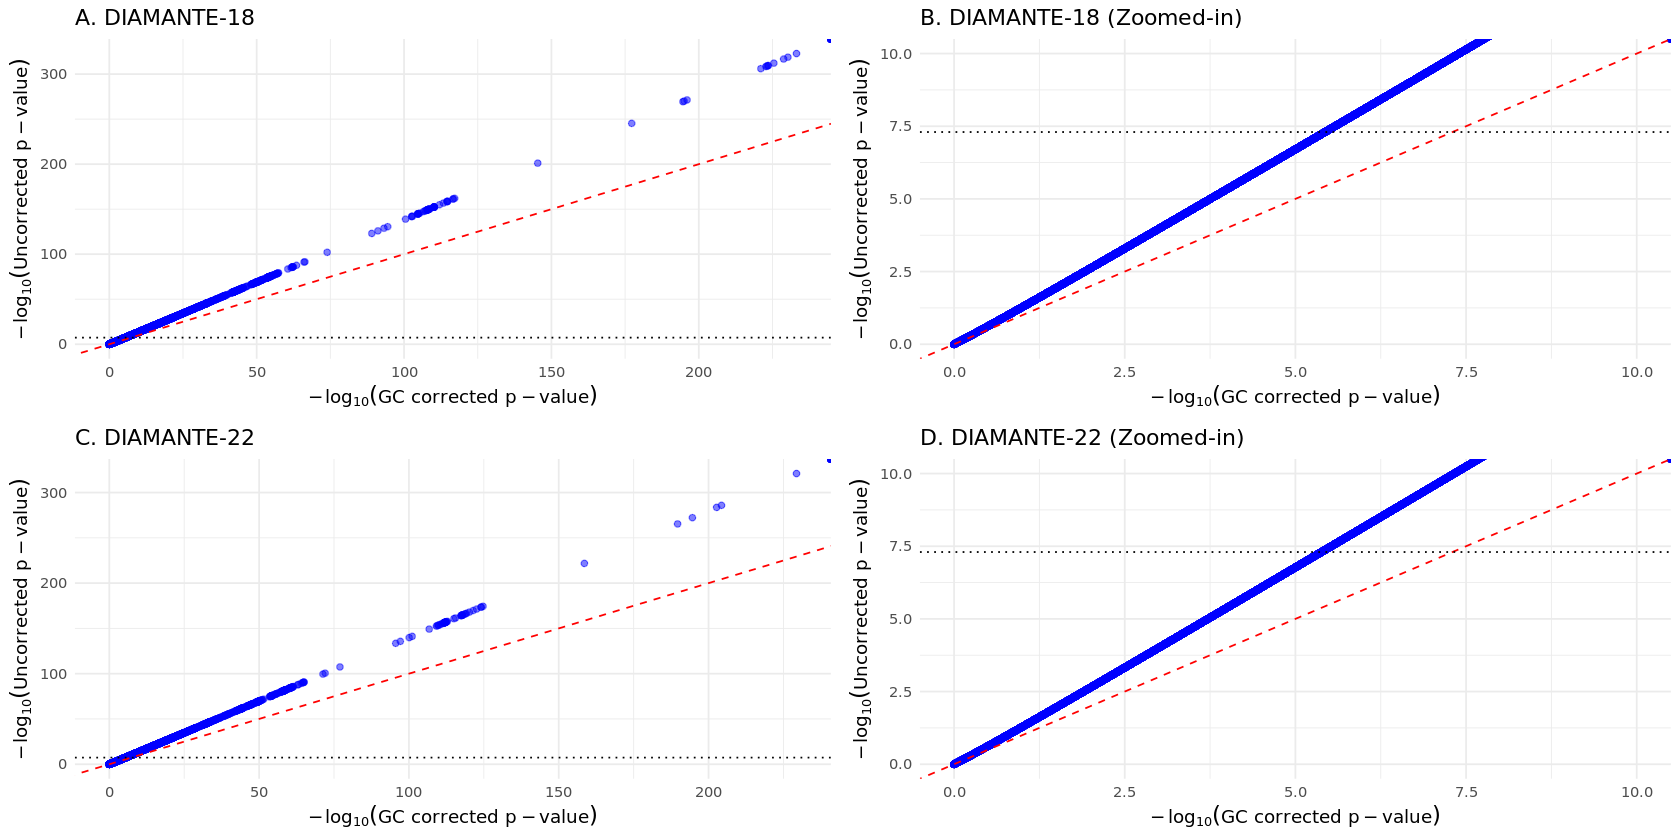

In [17]:
##################################################### Correlation plots ###############################################################
# Define significance threshold
threshold <- -log10(5e-08)

# --- DIAMANTE-18 Plots ---
qqplot_diam18 <- ggplot(diamante18, aes(x = -log10(as.numeric(double_gc_p_values)), y = -log10(as.numeric(single_gc_p_values)))) +
  geom_point(alpha = 0.5, color = "blue") +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "red") +
  geom_hline(yintercept = threshold, linetype = "dotted", color = "black") +  # Horizontal threshold line
  theme_minimal() +
  labs(
    x = expression(-log[10](GC~corrected~p-value)),
    y = expression(-log[10](Uncorrected~p-value)),
    title = "A. DIAMANTE-18"
  )

zoom_qqplot_diam18 <- ggplot(diamante18, aes(x = -log10(as.numeric(double_gc_p_values)), y = -log10(as.numeric(single_gc_p_values)))) +
  geom_point(alpha = 0.5, color = "blue") +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "red") +
  geom_hline(yintercept = threshold, linetype = "dotted", color = "black") +  
  coord_cartesian(ylim = c(0, 10), xlim = c(0, 10)) +  
  theme_minimal() +
  labs(
    x = expression(-log[10](GC~corrected~p-value)),
    y = expression(-log[10](Uncorrected~p-value)),
    title = "B. DIAMANTE-18 (Zoomed-in)"
  )

# --- DIAMANTE-22 Plots ---
qqplot_diam22 <- ggplot(diamante22, aes(x = -log10(as.numeric(double_gc_p_values)), y = -log10(as.numeric(single_gc_p_values)))) +
  geom_point(alpha = 0.5, color = "blue") +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "red") +
  geom_hline(yintercept = threshold, linetype = "dotted", color = "black") +  
  theme_minimal() +
  labs(
    x = expression(-log[10](GC~corrected~p-value)),
    y = expression(-log[10](Uncorrected~p-value)),
    title = "C. DIAMANTE-22"
  )

zoom_qqplot_diam22 <- ggplot(diamante22, aes(x = -log10(as.numeric(double_gc_p_values)), y = -log10(as.numeric(single_gc_p_values)))) +
  geom_point(alpha = 0.5, color = "blue") +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "red") +
  geom_hline(yintercept = threshold, linetype = "dotted", color = "black") +  
  coord_cartesian(ylim = c(0, 10), xlim = c(0, 10)) +  
  theme_minimal() +
  labs(
    x = expression(-log[10](GC~corrected~p-value)),
    y = expression(-log[10](Uncorrected~p-value)),
    title = "D. DIAMANTE-22 (Zoomed-in)"
  )

# Combine all four plots into a 2x2 layout
final_qqplot <- plot_grid(qqplot_diam18, zoom_qqplot_diam18, qqplot_diam22, zoom_qqplot_diam22, 
                          ncol = 2, nrow = 2, labels = NULL)
final_qqplot

In [22]:
#comparing Diamante-18 and Diamante-22
diamante18_comm_1 <- semi_join(diamante18, comm_snps_1, by = "id")
diamante22_comm_1 <- semi_join(diamante22, comm_snps_1, by = "id")
#GC unadjusted
#For DIAMANTE-18
sig_diamante18_comm_1 <- subset(diamante18_comm_1, as.numeric(diamante18_comm_1$single_gc_p_values) <= 0.00000005)
#For DIAMANTE-22
sig_diamante22_comm_1 <- subset(diamante22_comm_1, as.numeric(diamante22_comm_1$single_gc_p_values) <= 0.00000005)
#calculating rate of replication
#including all variants
overlap_unadj <- inner_join(sig_diamante18_comm_1, sig_diamante22_comm_1, by = "id")
overlap_unadj <- subset(overlap_unadj, overlap_unadj$direction_of_effect.x == overlap_unadj$direction_of_effect.y)
print(dim(overlap_unadj))
replication100_unadj <- (length(overlap_unadj$id)/length(sig_diamante18_comm_1$id)*100)

#GC adjusted
#For DIAMANTE-18
sig_adj_diamante18_comm_1 <- subset(diamante18_comm_1, as.numeric(diamante18_comm_1$double_gc_p_values) <= 0.00000005)
#calculating rate of replication
#including all variants
overlap_adj <- inner_join(sig_adj_diamante18_comm_1, sig_diamante22_comm_1, by = "id")
overlap_adj <- subset(overlap_adj, overlap_adj$direction_of_effect.x == overlap_adj$direction_of_effect.y)
print(dim(overlap_adj))
replication100_adj <- (length(overlap_adj$id)/length(sig_diamante18_comm_1$id)*100)

#identifying true associations not replicated 
unreplicated_diam18_diam22 <- anti_join(overlap_unadj, overlap_adj, by = "id")
#identifying true associations replicated 
replicated_diam18_diam22 <- semi_join(overlap_unadj, overlap_adj, by = "id")

[1] 18266    27
[1] 9907   27


In [23]:
#checking the number of TAs lost in the DIAMANTE-18 and DIAMANTE-22 comparison being replicated in T2DGGI-24
sig_t2dggi <- subset(t2dggi, as.numeric(t2dggi$`P-value`) <= 0.00000005)
dim(inner_join(unreplicated_diam18_diam22, sig_t2dggi, by = "id"))

[1] 8015   43

In [24]:
#Calculating True positive rate (TPR) and False positive rate (FPR) 
#Before GC-correction
TP <- length(overlap_unadj$id)

#TN
unsig_unadj_diamante18 <- subset(diamante18_comm_1, as.numeric(diamante18_comm_1$single_gc_p_values) > 0.00000005)
unsig_unadj_diamante22 <- subset(diamante22_comm_1, as.numeric(diamante22_comm_1$single_gc_p_values) > 0.00000005)
common_unsig_unadj <- inner_join(unsig_unadj_diamante18, unsig_unadj_diamante22, by = "id")
TN <- length(common_unsig_unadj$id)

#FP
FP_temp1 <- inner_join(sig_diamante18_comm_1, unsig_unadj_diamante22, by = "id")
FP_temp2 <- inner_join(sig_diamante18_comm_1, sig_diamante22_comm_1, by = "id")
FP_temp2 <- subset(FP_temp2, FP_temp2$direction_of_effect.x != FP_temp2$direction_of_effect.y)
FP_temp <- rbind(FP_temp1, FP_temp2)
FP_temp_duplicates <- duplicated(FP_temp$id)
FP_temp <- FP_temp[!FP_temp_duplicates, ]
FP <- length(FP_temp$id)

#FN
FN_temp <- inner_join(unsig_unadj_diamante18, sig_diamante22_comm_1, by = "id")
FN <- length(FN_temp$id)

#Calculating rates
FPR_beforeGC <- FP / (FP + TN)
#TPR or Recall
TPR_beforeGC <- TP / (TP + FN)
#Precision 
precision_beforeGC <- TP / (TP + FP)

#After GC-correction
TP <- length(overlap_adj$id)

#TN
unsig_adj_diamante18 <- subset(diamante18_comm_1, as.numeric(diamante18_comm_1$double_gc_p_values) > 0.00000005)
common_unsig_adj <- inner_join(unsig_adj_diamante18, unsig_unadj_diamante22, by = "id")
TN <- length(common_unsig_adj$id)

#FP
FP_temp1 <- inner_join(sig_adj_diamante18_comm_1, unsig_unadj_diamante22, by = "id")
FP_temp2 <- inner_join(sig_adj_diamante18_comm_1, sig_diamante22_comm_1, by = "id")
FP_temp2 <- subset(FP_temp2, FP_temp2$direction_of_effect.x != FP_temp2$direction_of_effect.y)
FP_temp <- rbind(FP_temp1, FP_temp2)
FP_temp_duplicates <- duplicated(FP_temp$id)
FP_temp <- FP_temp[!FP_temp_duplicates, ]
FP <- length(FP_temp$id)

#FN
FN_temp <- inner_join(unsig_adj_diamante18, sig_diamante22_comm_1, by = "id")
FN <- length(FN_temp$id)

#Calculating rates
#FPR
FPR_afterGC <- FP / (FP + TN)
#TPR or Recall
TPR_afterGC <- TP / (TP + FN)
#Precision 
precision_afterGC <- TP / (TP + FP)

In [25]:
FPR_beforeGC
TPR_beforeGC
precision_beforeGC
FPR_afterGC
TPR_afterGC
precision_afterGC

[1] 0.0001036224

[1] 0.8729271

[1] 0.9450538

[1] 0

[1] 0.4734528

[1] 1

In [ ]:
#comparing Diamante-18 and T2D-GGI
diamante18_comm_2 <- semi_join(diamante18, comm_snps_2, by = "id")
t2dggi_comm_1 <- semi_join(t2dggi, comm_snps_2, by = "id")
#GC unadjusted
#For DIAMANTE-18
sig_diamante18_comm_2 <- subset(diamante18_comm_2, as.numeric(diamante18_comm_2$single_gc_p_values) <= 0.00000005)
#For T2DGGI
sig_t2dggi_comm_1 <- subset(t2dggi_comm_1, as.numeric(t2dggi_comm_1$`P-value`) <= 0.00000005)
#calculating rate of replication
#including all variants
overlap_unadj <- inner_join(sig_diamante18_comm_2, sig_t2dggi_comm_1, by = "id")
overlap_unadj <- subset(overlap_unadj, overlap_unadj$direction_of_effect.x == overlap_unadj$direction_of_effect.y)
print(dim(overlap_unadj))
replication101_unadj <- (length(overlap_unadj$id)/length(sig_diamante18_comm_2$id)*100)

#GC adjusted
#For DIAMANTE-18
sig_adj_diamante18_comm_2 <- subset(diamante18_comm_2, as.numeric(diamante18_comm_2$double_gc_p_values) <= 0.00000005)
#calculating rate of replication
#including all variants
overlap_adj <- inner_join(sig_adj_diamante18_comm_2, sig_t2dggi_comm_1, by = "id")
overlap_adj <- subset(overlap_adj, overlap_adj$direction_of_effect.x == overlap_adj$direction_of_effect.y)
print(dim(overlap_adj))
replication101_adj <- (length(overlap_adj$id)/length(sig_diamante18_comm_2$id)*100)

#identifying true associations not replicated 
unreplicated_diam18_t2dggi <- anti_join(overlap_unadj, overlap_adj, by = "id")
#identifying true associations replicated 
replicated_diam18_t2dggi <- semi_join(overlap_unadj, overlap_adj, by = "id")

[1] 9893   30
[1] 9893   30


In [27]:
#Calculating True positive rate (TPR) and False positive rate (FPR) 
#Before GC-correction
TP <- length(overlap_unadj$id)

#TN
unsig_unadj_diamante18 <- subset(diamante18_comm_2, as.numeric(diamante18_comm_2$single_gc_p_values) > 0.00000005)
unsig_unadj_t2dggi <- subset(t2dggi_comm_1, as.numeric(t2dggi_comm_1$`P-value`) > 0.00000005)
common_unsig_unadj <- inner_join(unsig_unadj_diamante18, unsig_unadj_t2dggi, by = "id")
TN <- length(common_unsig_unadj$id)

#FP
FP_temp1 <- inner_join(sig_diamante18_comm_2, unsig_unadj_t2dggi, by = "id")
FP_temp2 <- inner_join(sig_diamante18_comm_2, sig_t2dggi_comm_1, by = "id")
FP_temp2 <- subset(FP_temp2, FP_temp2$direction_of_effect.x != FP_temp2$direction_of_effect.y)
FP_temp <- rbind(FP_temp1, FP_temp2)
FP_temp_duplicates <- duplicated(FP_temp$id)
FP_temp <- FP_temp[!FP_temp_duplicates, ]
FP <- length(FP_temp$id)

#FN
FN_temp <- inner_join(unsig_unadj_diamante18, sig_t2dggi_comm_1, by = "id")
FN <- length(FN_temp$id)

#Calculating rates
FPR_beforeGC <- FP / (FP + TN)
#TPR or Recall
TPR_beforeGC <- TP / (TP + FN)
#Precision 
precision_beforeGC <- TP / (TP + FP)

#After GC-correction
TP <- length(overlap_adj$id)

#TN
unsig_adj_diamante18 <- subset(diamante18_comm_2, as.numeric(diamante18_comm_2$double_gc_p_values) > 0.00000005)
common_unsig_adj <- inner_join(unsig_adj_diamante18, unsig_unadj_t2dggi, by = "id")
TN <- length(common_unsig_adj$id)

#FP
FP_temp1 <- inner_join(sig_adj_diamante18_comm_2, unsig_unadj_t2dggi, by = "id")
FP_temp2 <- inner_join(sig_adj_diamante18_comm_2, sig_t2dggi_comm_1, by = "id")
FP_temp2 <- subset(FP_temp2, FP_temp2$direction_of_effect.x != FP_temp2$direction_of_effect.y)
FP_temp <- rbind(FP_temp1, FP_temp2)
FP_temp_duplicates <- duplicated(FP_temp$id)
FP_temp <- FP_temp[!FP_temp_duplicates, ]
FP <- length(FP_temp$id)

#FN
FN_temp <- inner_join(unsig_adj_diamante18, sig_t2dggi_comm_1, by = "id")
FN <- length(FN_temp$id)

#Calculating rates
#FPR
FPR_afterGC <- FP / (FP + TN)
#TPR or Recall
TPR_afterGC <- TP / (TP + FN)
#Precision 
precision_afterGC <- TP / (TP + FP)

In [28]:
FPR_beforeGC
TPR_beforeGC
precision_beforeGC
FPR_afterGC
TPR_afterGC
precision_afterGC

[1] 0.0000488009

[1] 0.2899421

[1] 0.9742343

[1] 0.000001371913

[1] 0.1523312

[1] 0.9985869

In [29]:
#comparing Diamante-22 and T2D-GGI
diamante22_comm_1 <- semi_join(diamante22, comm_snps_3, by = "id")
t2dggi_comm_2 <- semi_join(t2dggi, comm_snps_3, by = "id")
#GC unadjusted
#For DIAMANTE-22
sig_diamante22_comm_1 <- subset(diamante22_comm_1, as.numeric(diamante22_comm_1$single_gc_p_values) <= 0.00000005)
#For T2DGGI
sig_t2dggi_comm_2 <- subset(t2dggi_comm_2, as.numeric(t2dggi_comm_2$`P-value`) <= 0.00000005)
#calculating rate of replication
#including all variants
overlap_unadj <- inner_join(sig_diamante22_comm_1, sig_t2dggi_comm_2, by = "id")
overlap_unadj <- subset(overlap_unadj, overlap_unadj$direction_of_effect.x == overlap_unadj$direction_of_effect.y)
print(dim(overlap_unadj))
replication102_unadj <- (length(overlap_unadj$id)/length(sig_diamante22_comm_1$id)*100)

#GC adjusted
#For DIAMANTE-22
sig_adj_diamante22_comm_1 <- subset(diamante22_comm_1, as.numeric(diamante22_comm_1$double_gc_p_values) <= 0.00000005)
#calculating rate of replication
#including all variants
overlap_adj <- inner_join(sig_adj_diamante22_comm_1, sig_t2dggi_comm_2, by = "id")
overlap_adj <- subset(overlap_adj, overlap_adj$direction_of_effect.x == overlap_adj$direction_of_effect.y)
print(dim(overlap_adj))
replication102_adj <- (length(overlap_adj$id)/length(sig_diamante22_comm_1$id)*100)

#identifying true associations not replicated 
unreplicated_diam22_t2dggi <- anti_join(overlap_unadj, overlap_adj, by = "id")
#identifying true associations replicated 
replicated_diam22_t2dggi <- semi_join(overlap_unadj, overlap_adj, by = "id")

[1] 20405    30
[1] 10390    30


In [30]:
#Calculating True positive rate (TPR) and False positive rate (FPR) 
#Before GC-correction
TP <- length(overlap_unadj$id)

#TN
unsig_unadj_diamante22 <- subset(diamante22_comm_1, as.numeric(diamante22_comm_1$single_gc_p_values) > 0.00000005)
unsig_unadj_t2dggi <- subset(t2dggi_comm_2, as.numeric(t2dggi_comm_2$`P-value`) > 0.00000005)
common_unsig_unadj <- inner_join(unsig_unadj_diamante22, unsig_unadj_t2dggi, by = "id")
TN <- length(common_unsig_unadj$id)

#FP
FP_temp1 <- inner_join(sig_diamante22_comm_1, unsig_unadj_t2dggi, by = "id")
FP_temp2 <- inner_join(sig_diamante22_comm_1, sig_t2dggi_comm_2, by = "id")
FP_temp2 <- subset(FP_temp2, FP_temp2$direction_of_effect.x != FP_temp2$direction_of_effect.y)
FP_temp <- rbind(FP_temp1, FP_temp2)
FP_temp_duplicates <- duplicated(FP_temp$id)
FP_temp <- FP_temp[!FP_temp_duplicates, ]
FP <- length(FP_temp$id)

#FN
FN_temp <- inner_join(unsig_unadj_diamante22, sig_t2dggi_comm_2, by = "id")
FN <- length(FN_temp$id)

#Calculating rates
FPR_beforeGC <- FP / (FP + TN)
#TPR or Recall
TPR_beforeGC <- TP / (TP + FN)
#Precision 
precision_beforeGC <- TP / (TP + FP)

#After GC-correction
TP <- length(overlap_adj$id)

#TN
unsig_adj_diamante22 <- subset(diamante22_comm_1, as.numeric(diamante22_comm_1$double_gc_p_values) > 0.00000005)
common_unsig_adj <- inner_join(unsig_adj_diamante22, unsig_unadj_t2dggi, by = "id")
TN <- length(common_unsig_adj$id)

#FP
FP_temp1 <- inner_join(sig_adj_diamante22_comm_1, unsig_unadj_t2dggi, by = "id")
FP_temp2 <- inner_join(sig_adj_diamante22_comm_1, sig_t2dggi_comm_2, by = "id")
FP_temp2 <- subset(FP_temp2, FP_temp2$direction_of_effect.x != FP_temp2$direction_of_effect.y)
FP_temp <- rbind(FP_temp1, FP_temp2)
FP_temp_duplicates <- duplicated(FP_temp$id)
FP_temp <- FP_temp[!FP_temp_duplicates, ]
FP <- length(FP_temp$id)

#FN
FN_temp <- inner_join(unsig_adj_diamante22, sig_t2dggi_comm_2, by = "id")
FN <- length(FN_temp$id)

#Calculating rates
#FPR
FPR_afterGC <- FP / (FP + TN)
#TPR or Recall
TPR_afterGC <- TP / (TP + FN)
#Precision 
precision_afterGC <- TP / (TP + FP)

In [31]:
FPR_beforeGC
TPR_beforeGC
precision_beforeGC
FPR_afterGC
TPR_afterGC
precision_afterGC

[1] 0.00005095676

[1] 0.3141938

[1] 0.9751493

[1] 0.000004311726

[1] 0.159984

[1] 0.995783

%-SNPs-replicated,group_var,studies,total_sample_size
<dbl>,<fct>,<chr>,<dbl>
94.50538,Before-correction,DIAMANTE-18.vs.DIAMANTE-22,1832100
97.42343,Before-correction,DIAMANTE-18.vs.T2DGGI-24,2710147
97.51493,Before-correction,DIAMANTE-22.vs.T2DGGI-24,2745987
51.25724,After-correction,DIAMANTE-18.vs.DIAMANTE-22,1832100
51.18481,After-correction,DIAMANTE-18.vs.T2DGGI-24,2710147
49.65352,After-correction,DIAMANTE-22.vs.T2DGGI-24,2745987


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Removed 1 row containing missing values (`geom_line()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_label()`).”


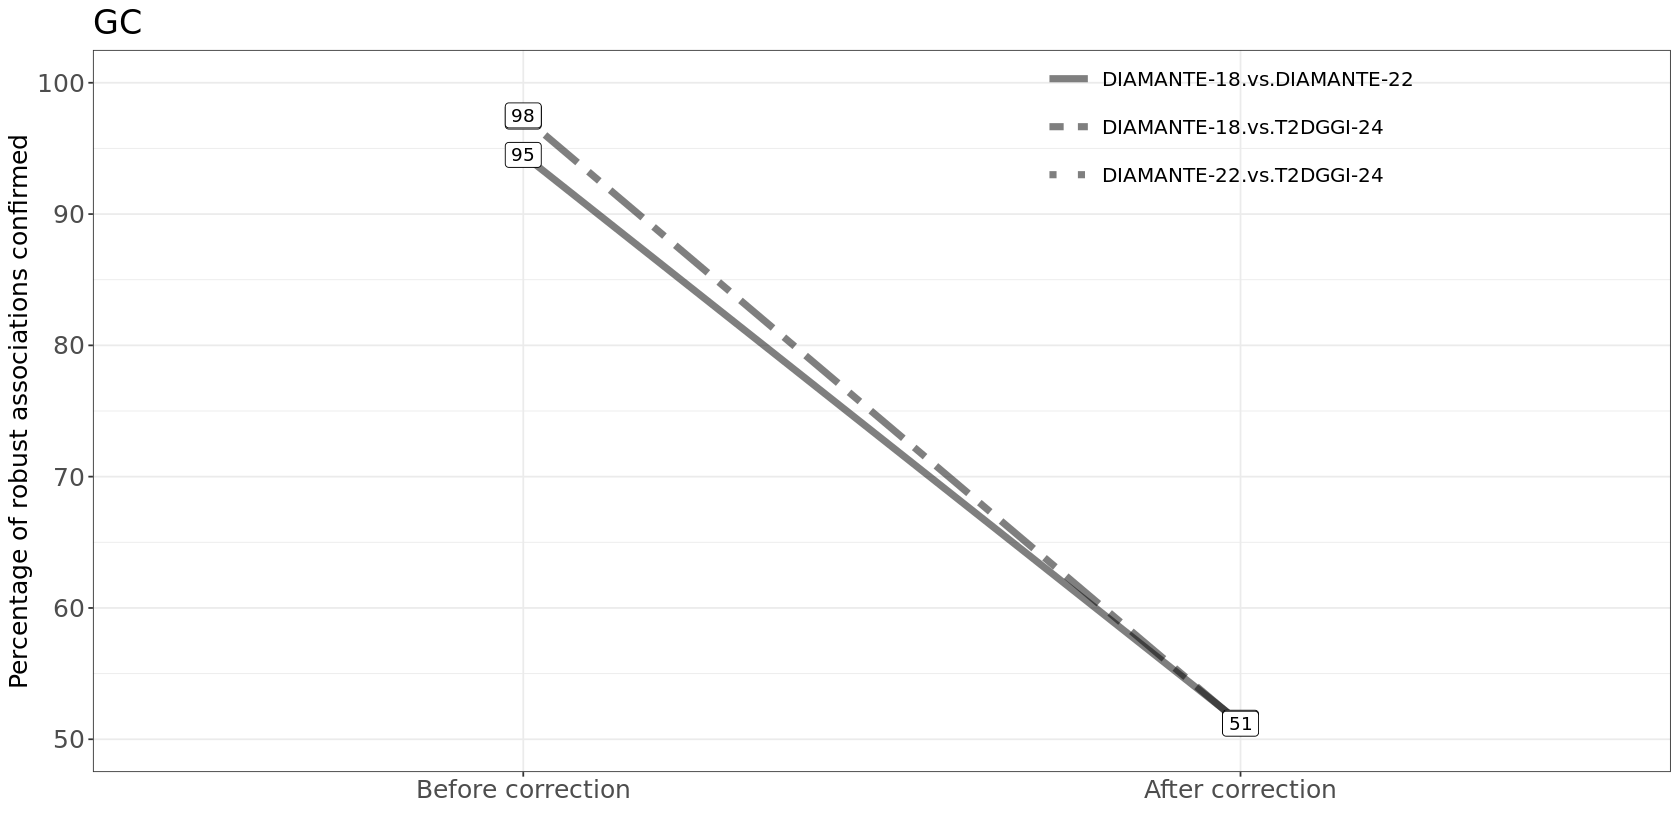

In [32]:
#plotting the trend
lambda_values <- c(replication100_unadj, replication101_unadj, replication102_unadj, replication100_adj, replication101_adj, replication102_adj)
trend.plot <- data.frame(lambda_values, c("Before-correction","Before-correction","Before-correction","After-correction", "After-correction", "After-correction"), c("DIAMANTE-18.vs.DIAMANTE-22", "DIAMANTE-18.vs.T2DGGI-24", "DIAMANTE-22.vs.T2DGGI-24"), c(1832100, 2710147, 2745987))
colnames(trend.plot) <- c("%-SNPs-replicated", "group_var", "studies", "total_sample_size")
trend.plot$group_var <- factor(trend.plot$group_var, levels=c("Before-correction","After-correction"))
trend.plot
ggplot(trend.plot, aes(x = group_var, y = `%-SNPs-replicated`, linetype = studies, group = studies)) +
  scale_x_discrete(labels = function(x) gsub("-", " ", x)) +
  geom_line(size = 2, alpha = 0.5, show.legend = T) +
  scale_linetype_manual(values=c("solid", "twodash", "dotted")) +
  geom_label(aes(label = round(`%-SNPs-replicated`)), show_guide = F) + ggtitle("GC") +
  ylab("Percentage of robust associations confirmed") +
  xlab("") + theme_bw() + ylim(50, 100) +
  theme(plot.title = element_text(size=20), axis.text = element_text(size = 15), legend.position = c(0.72, 0.90), legend.text = element_text(size = 12), legend.title = element_blank(), axis.title = element_text(size = 15), legend.key = element_blank(), legend.background = element_blank(), legend.key.size = unit(2,"line"))
plot_gc <- ggplot(trend.plot, aes(x = group_var, y = `%-SNPs-replicated`, linetype = studies, group = studies)) +
  scale_x_discrete(labels = function(x) gsub("-", " ", x)) +
  geom_line(size = 2, alpha = 0.5, show.legend = T) +
  scale_linetype_manual(values=c("solid", "twodash", "dotted")) +
  geom_label(aes(label = round(`%-SNPs-replicated`)), show_guide = F) + ggtitle("GC") +
  ylab("Percentage of robust associations confirmed") +
  xlab("") + theme_bw() + ylim(50, 100) +
  theme(plot.title = element_text(size=20), axis.text = element_text(size = 15), legend.position = c(0.72, 0.90), legend.text = element_text(size = 12), legend.title = element_blank(), axis.title = element_text(size = 15), legend.key = element_blank(), legend.background = element_blank(), legend.key.size = unit(2,"line"))


In [73]:
#writing info of SNPs which are unreplicated after correction to a file 
fwrite(unreplicated_diam18_diam22, "/lustre/groups/itg/teams/zeggini/users/archit.singh/lambda/independent_signals_analysis/DIAMANTE-18/new_analysis_unreplicated_diam18_diam22.txt", sep = "\t")
fwrite(unreplicated_diam18_t2dggi, "/lustre/groups/itg/teams/zeggini/users/archit.singh/lambda/independent_signals_analysis/DIAMANTE-18/new_analysis_unreplicated_diam18_t2dggi.txt", sep = "\t")
fwrite(unreplicated_diam22_t2dggi, "/lustre/groups/itg/teams/zeggini/users/archit.singh/lambda/independent_signals_analysis/DIAMANTE-22/new_analysis_unreplicated_diam22_t2dggi.txt", sep = "\t")

In [33]:
#For figure 2 in the manuscript
#combining results pdf from GC and LDSR correction into one figure
ldsr <- fread("/lustre/groups/itg/teams/zeggini/users/archit.singh/lambda/plots_for_manuscript/ldsr_values.txt", header = TRUE)
ldsr$group_var <- factor(ldsr$group_var, levels=c("Before-correction","After-correction"))
plot_ldsr <- ggplot(ldsr, aes(x = group_var, y = `%-SNPs-replicated`, linetype = studies, group = studies)) +
  scale_x_discrete(labels = function(x) gsub("-", " ", x)) +
  geom_line(size = 2, alpha = 0.5, show.legend = T) + ggtitle("LDSR") +
  scale_linetype_manual(values=c("solid", "twodash", "dotted")) +
  geom_label(aes(label = round(`%-SNPs-replicated`)), show_guide = F) +
  ylab("Percentage of robust associations confirmed") +
  xlab("") + theme_bw() + ylim(50, 100) +
  theme(plot.title = element_text(size=20), axis.text = element_text(size = 15), legend.position = c(0.72, 0.90), legend.text = element_text(size = 12), legend.title = element_blank(), axis.title = element_text(size = 15), legend.key = element_blank(), legend.background = element_blank(), legend.key.size = unit(2,"line"))

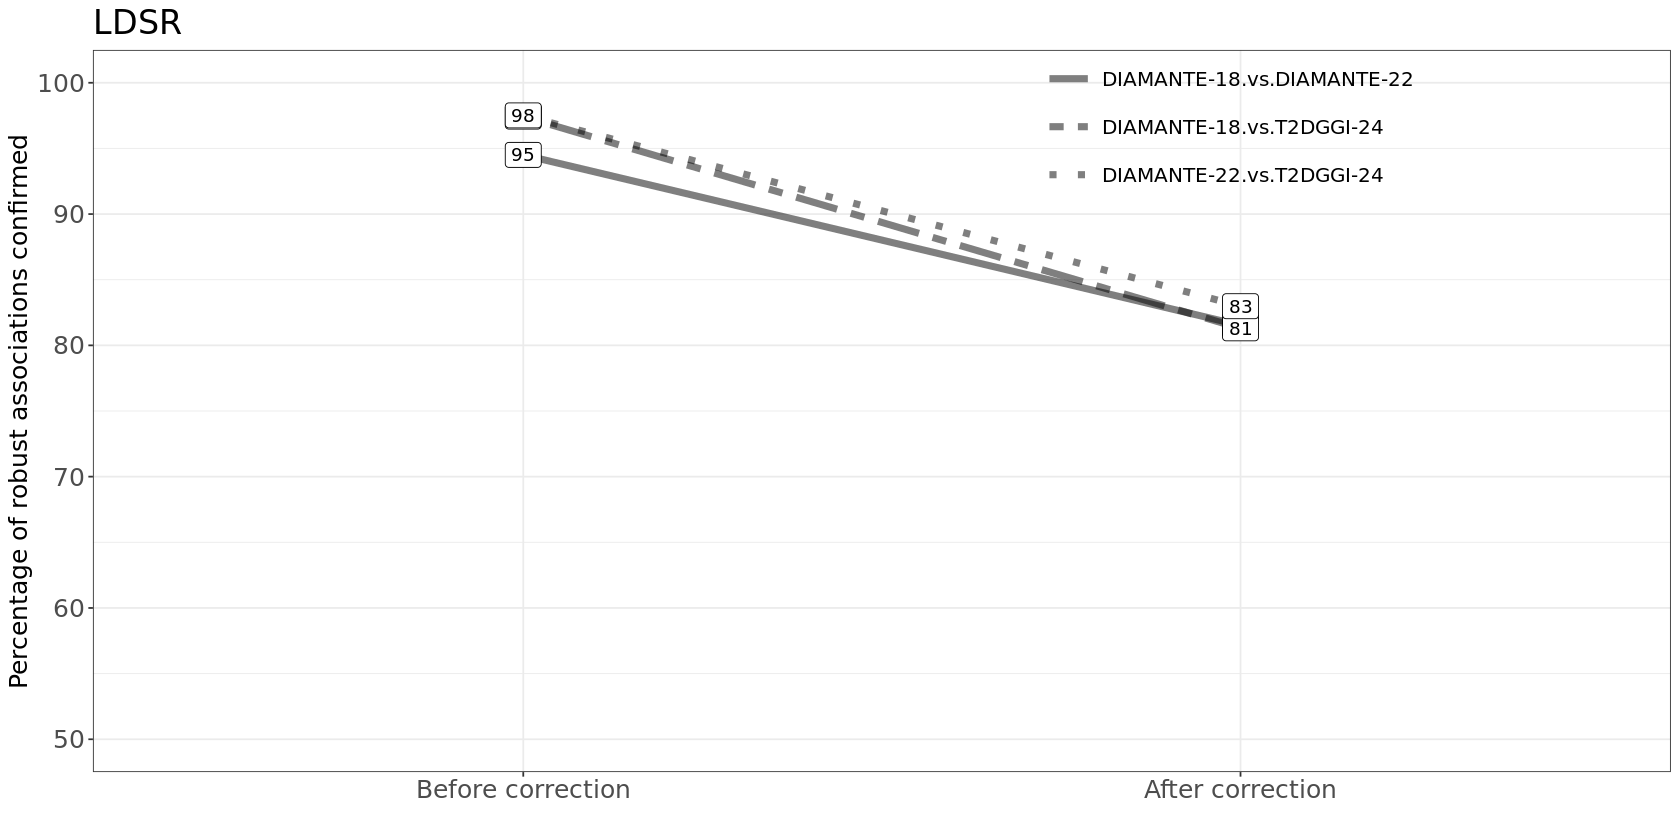

In [34]:
plot_ldsr

Warning message:
“Removed 1 row containing missing values (`geom_line()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_label()`).”


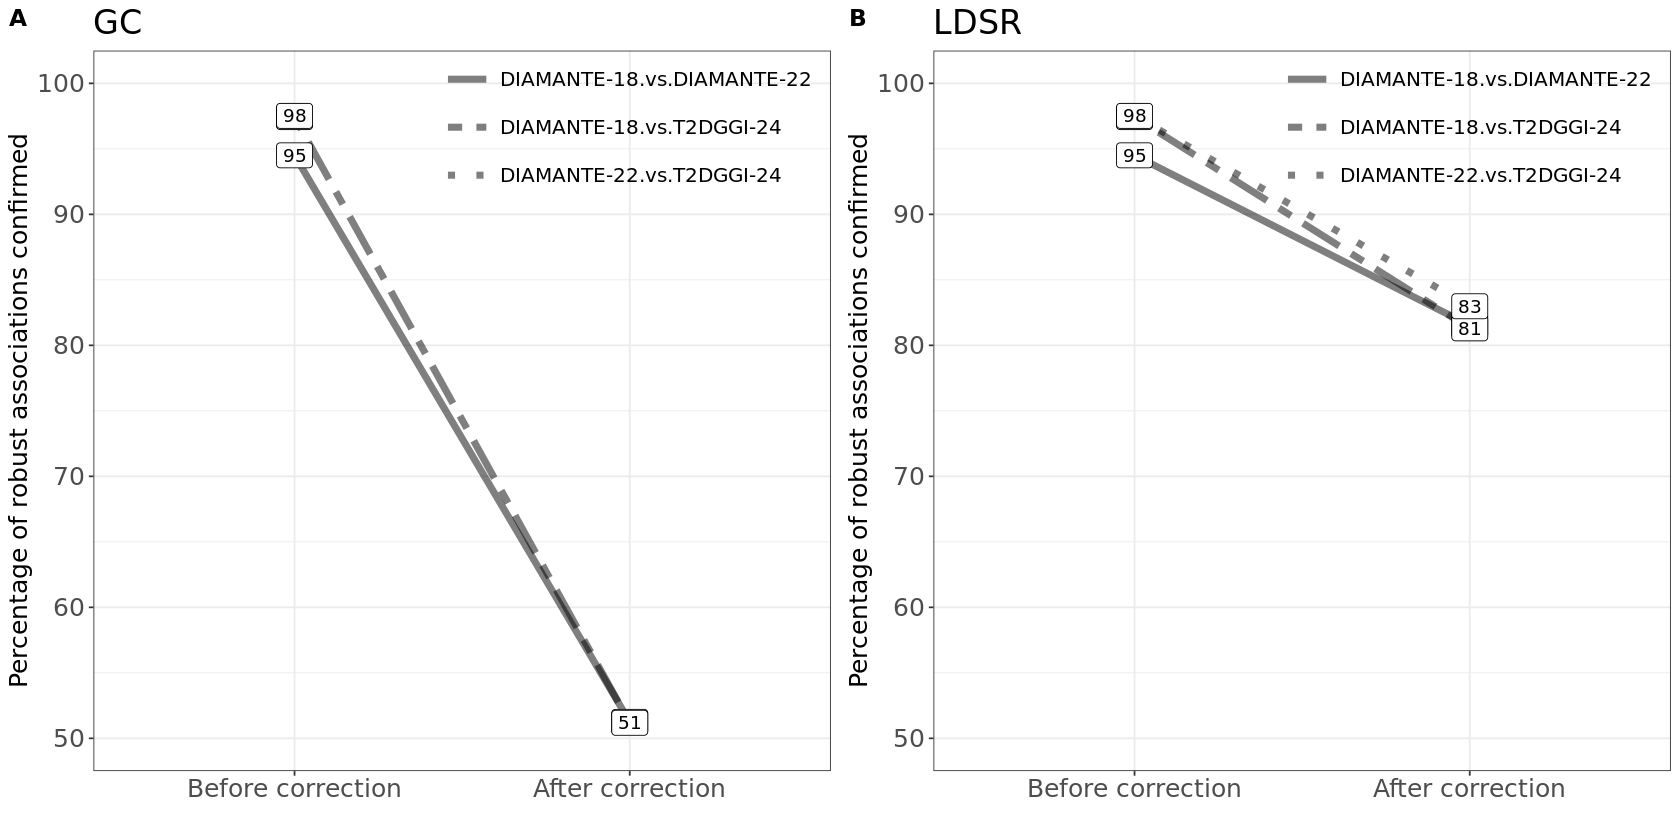

In [35]:
#combining figures
options(repr.plot.width = 14, repr.plot.height =7) 
plot_2 <- ggarrange(plot_gc, plot_ldsr, labels = c("A", "B"))
plot_2
ggsave(plot_2, filename = "/lustre/groups/itg/teams/zeggini/users/archit.singh/lambda/plots_for_manuscript/figure_2.pdf", width=14, height=7, units="in")